## Preparation

In [60]:
import numpy as np
import polars as pl

import plotly.io as pio
import plotly.express as px
from plotly.subplots import make_subplots

from statsforecast import StatsForecast
import statsforecast.models as sfm
from tsaplots_plotly import plot_acf, plot_pacf

from sklearn.model_selection import train_test_split
from sklearn.metrics import root_mean_squared_error as rmse

In [61]:
pio.renderers.default = 'svg'

In [62]:
df = {
    'train': pl.read_csv('data/train.csv', infer_schema_length = 70000),
    'test': pl.read_csv('data/test.csv', infer_schema_length = 30000),
    'store': pl.read_csv('data/store.csv')
}

## Data Cleaning and Engineering

See train and store data

In [63]:
# Test data is similar, just without sales and customers
df['train']

Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
i64,i64,str,i64,i64,i64,i64,str,i64
1,5,"""2015-07-31""",5263,555,1,1,"""0""",1
2,5,"""2015-07-31""",6064,625,1,1,"""0""",1
3,5,"""2015-07-31""",8314,821,1,1,"""0""",1
4,5,"""2015-07-31""",13995,1498,1,1,"""0""",1
5,5,"""2015-07-31""",4822,559,1,1,"""0""",1
…,…,…,…,…,…,…,…,…
1111,2,"""2013-01-01""",0,0,0,0,"""a""",1
1112,2,"""2013-01-01""",0,0,0,0,"""a""",1
1113,2,"""2013-01-01""",0,0,0,0,"""a""",1


In [64]:
df['store']

Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
i64,str,str,i64,i64,i64,i64,i64,i64,str
1,"""c""","""a""",1270,9,2008,0,null,null,""""""
2,"""a""","""a""",570,11,2007,1,13,2010,"""Jan,Apr,Jul,Oct"""
3,"""a""","""a""",14130,12,2006,1,14,2011,"""Jan,Apr,Jul,Oct"""
4,"""c""","""c""",620,9,2009,0,null,null,""""""
5,"""a""","""a""",29910,4,2015,0,null,null,""""""
…,…,…,…,…,…,…,…,…,…
1111,"""a""","""a""",1900,6,2014,1,31,2013,"""Jan,Apr,Jul,Oct"""
1112,"""c""","""c""",1880,4,2006,0,null,null,""""""
1113,"""a""","""c""",9260,null,null,0,null,null,""""""


The dataset contains some values I'm not familiar with, let's see all the possible values

In [65]:
def print_unique(df: pl.DataFrame, max_to_show: int = 100):
    for col in df:
        nullable = ', nullable' if col.has_nulls() else ''
        # Column name, column type, unique value count, nullable or not
        print(f'{col.name} ({col.dtype}, {col.n_unique()}{nullable}): ', end = '')

        if col.n_unique() <= max_to_show:
            # Show the list of unique values
            print(col.unique().sort().to_list())
        else:
            print('[TOO MANY TO SHOW]')

    print()

print('* Train data *')
print_unique(df['train'])

print('* Test data *')
print_unique(df['test'])

print('* Store data *')
print_unique(df['store'])

* Train data *
Store (Int64, 1115): [TOO MANY TO SHOW]
DayOfWeek (Int64, 7): [1, 2, 3, 4, 5, 6, 7]
Date (String, 942): [TOO MANY TO SHOW]
Sales (Int64, 21734): [TOO MANY TO SHOW]
Customers (Int64, 4086): [TOO MANY TO SHOW]
Open (Int64, 2): [0, 1]
Promo (Int64, 2): 

[0, 1]
StateHoliday (String, 4): ['0', 'a', 'b', 'c']
SchoolHoliday (Int64, 2): [0, 1]

* Test data *
Id (Int64, 41088): [TOO MANY TO SHOW]
Store (Int64, 856): [TOO MANY TO SHOW]
DayOfWeek (Int64, 7): [1, 2, 3, 4, 5, 6, 7]
Date (String, 48): ['2015-08-01', '2015-08-02', '2015-08-03', '2015-08-04', '2015-08-05', '2015-08-06', '2015-08-07', '2015-08-08', '2015-08-09', '2015-08-10', '2015-08-11', '2015-08-12', '2015-08-13', '2015-08-14', '2015-08-15', '2015-08-16', '2015-08-17', '2015-08-18', '2015-08-19', '2015-08-20', '2015-08-21', '2015-08-22', '2015-08-23', '2015-08-24', '2015-08-25', '2015-08-26', '2015-08-27', '2015-08-28', '2015-08-29', '2015-08-30', '2015-08-31', '2015-09-01', '2015-09-02', '2015-09-03', '2015-09-04', '2015-09-05', '2015-09-06', '2015-09-07', '2015-09-08', '2015-09-09', '2015-09-10', '2015-09-11', '2015-09-12', '2015-09-13', '2015-09-14', '2015-09-15', '2015-09-16', '2015-09-17']
Open (Int64, 3, nullable): [None, 0, 1]
Promo (Int64, 2): [0, 1]
StateHoliday (String

We will replace some of these values to be more clear according to the dataset [description](data/README.md), and also replace/fill null values

In [66]:
# Train and test data
for name in ['train', 'test']:
    df[name] = df[name].with_columns(
        pl.col('Date').cast(pl.Date),
        pl.col('StateHoliday').replace({
            '0': 'None',
            'a': 'Public',
            'b': 'Easter',
            'c': 'Christmas'
        }),
        pl.col('Open').fill_null(0)
    )

# Store data
df['store'] = df['store'].with_columns(
    pl.col('Assortment').replace({
        'a': 'Basic',
        'b': 'Extra',
        'c': 'Extended'
    }),
    # Median is used because distance usually won't grow when there's a future data
    # If the range can grow (e.g. sales), interpolation method may be better
    # We don't use zero distance either since it will strongly affect sales in reality
    pl.col('CompetitionDistance').fill_null(pl.col('CompetitionDistance').quantile(0.5, 'lower')),
    # Fill null date with 1-1-1 if the store doesn't have promo/competitor yet
    # We will construct a standard date type after this, which can't be zero/null
    # We don't use latest date because the model may speculate sales drop/spike near that date
    # If we use 1-1-1, theorically it won't affect sales since the earliest record is 2013
    pl.col('^(.*?)Since(Month|Year)$').fill_null(1),
    pl.col('^(.*?)SinceWeek$').clip(upper_bound = 48).fill_null(1),
    pl.col('PromoInterval').replace({'': 'None'})
)

# The previous changes to store data are not known immediately
# That's why we need the follow up change(s) after the first one
df['store'] = df['store'].with_columns(
    pl.date(
        pl.col('CompetitionOpenSinceYear'),
        pl.col('CompetitionOpenSinceMonth'),
        pl.lit(1)
    ).alias('CompetitionOpenSinceDate'),
    pl.date(
        pl.col('Promo2SinceYear'),
        pl.col('Promo2SinceWeek').truediv(4).ceil(),
        pl.lit(1)
    ).alias('Promo2SinceDate')
)

In [67]:
# Recheck values after change
print('* Train data *')
print_unique(df['train'])

print('* Test data *')
print_unique(df['test'])

print('* Store data *')
print_unique(df['store'])

* Train data *
Store (Int64, 1115): [TOO MANY TO SHOW]
DayOfWeek (Int64, 7): [1, 2, 3, 4, 5, 6, 7]
Date (Date, 942): [TOO MANY TO SHOW]
Sales (Int64, 21734): [TOO MANY TO SHOW]
Customers (Int64, 4086): [TOO MANY TO SHOW]
Open (Int64, 2): [0, 1]
Promo (Int64, 2): [0, 1]
StateHoliday (String, 4): ['Christmas', 'Easter', 'None', 'Public']
SchoolHoliday (Int64, 2): [0, 1]

* Test data *
Id (Int64, 41088): [TOO MANY TO SHOW]
Store (Int64, 856): [TOO MANY TO SHOW]
DayOfWeek (Int64, 7): [1, 2, 3, 4, 5, 6, 7]
Date (Date, 48): [datetime.date(2015, 8, 1), datetime.date(2015, 8, 2), datetime.date(2015, 8, 3), datetime.date(2015, 8, 4), datetime.date(2015, 8, 5), datetime.date(2015, 8, 6), datetime.date(2015, 8, 7), datetime.date(2015, 8, 8), datetime.date(2015, 8, 9), datetime.date(2015, 8, 10), datetime.date(2015, 8, 11), datetime.date(2015, 8, 12), datetime.date(2015, 8, 13), datetime.date(2015, 8, 14), datetime.date(2015, 8, 15), datetime.date(2015, 8, 16), datetime.date(2015, 8, 17), datetime

Good, there is no more null value. We will now add some features that may be useful for the model and further analysis

Other feature engineering can also be seen on [FastAI notebook](https://www.kaggle.com/code/hortonhearsafoo/fast-ai-lesson-3) (requires external data, I don't use that)

In [68]:
for name in ['train', 'test']:
    df[name] = df[name].with_columns(
        pl.col('Date').dt.year().alias('Year'),
        pl.col('Date').dt.month().alias('Month'),
        pl.col('Date').dt.day().alias('DayOfMonth'),
        # May be important too, we will evaluate it later
        pl.col('Date').dt.ordinal_day().alias('DayOfYear'),
        pl.col('Date').dt.week().alias('WeekOfYear'),
    )

    # Use simple season instead of external weather data
    # It's obviously not as good as external data though
    df[name] = df[name].with_columns(
        pl.col('Month').replace_strict({
            1: 'Winter', 2: 'Winter', 3: 'Spring',
            4: 'Spring', 5: 'Spring', 6: 'Summer',
            7: 'Summer', 8: 'Summer', 9: 'Fall',
            10: 'Fall', 11: 'Fall', 12: 'Winter',
        }).alias('Season')
    )

In [69]:
display(df['train'].head(1))
display(df['store'].head(1))

Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,Year,Month,DayOfMonth,DayOfYear,WeekOfYear,Season
i64,i64,date,i64,i64,i64,i64,str,i64,i32,i8,i8,i16,i8,str
1,5,2015-07-31,5263,555,1,1,"""None""",1,2015,7,31,212,31,"""Summer"""


Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,CompetitionOpenSinceDate,Promo2SinceDate
i64,str,str,f64,i64,i64,i64,i64,i64,str,date,date
1,"""c""","""Basic""",1270.0,9,2008,0,1,1,"""None""",2008-09-01,0001-01-01


Let's add some of the important store data to train and test data too (e.g. store type, assortment)

We will also create `CompetitionOpen` column that behave just like `Promo` column (true or false on that day), with the help of `CompetitionOpenSinceDate`

In [70]:
# Store columns to add to train/test data
cols = [
    'Store', 'StoreType', 'Assortment',
    'PromoInterval', 'Promo2SinceDate',
    'CompetitionDistance', 'CompetitionOpenSinceDate'
]

for name in ['train', 'test']:
    df[name] = df[name].join(
        df['store'].select(cols),
        on = 'Store',
        how = 'inner',
        maintain_order = 'left'
    )

    df[name] = df[name].with_columns(
        pl.when(pl.col('CompetitionOpenSinceDate') == pl.date(1, 1, 1)).then(pl.lit(0)). \
            when(pl.col('Date') >= pl.col('CompetitionOpenSinceDate')).then(pl.lit(1)). \
            otherwise(pl.lit(0)).alias('CompetitionOpen')
    )

In [71]:
# Check potential null value if there's still any
print(df['train'].null_count().sum_horizontal().item())
print(df['test'].null_count().sum_horizontal().item())

df['train'].head()

0
0


Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,Year,Month,DayOfMonth,DayOfYear,WeekOfYear,Season,StoreType,Assortment,PromoInterval,Promo2SinceDate,CompetitionDistance,CompetitionOpenSinceDate,CompetitionOpen
i64,i64,date,i64,i64,i64,i64,str,i64,i32,i8,i8,i16,i8,str,str,str,str,date,f64,date,i32
1,5,2015-07-31,5263,555,1,1,"""None""",1,2015,7,31,212,31,"""Summer""","""c""","""Basic""","""None""",0001-01-01,1270.0,2008-09-01,1
2,5,2015-07-31,6064,625,1,1,"""None""",1,2015,7,31,212,31,"""Summer""","""a""","""Basic""","""Jan,Apr,Jul,Oct""",2010-04-01,570.0,2007-11-01,1
3,5,2015-07-31,8314,821,1,1,"""None""",1,2015,7,31,212,31,"""Summer""","""a""","""Basic""","""Jan,Apr,Jul,Oct""",2011-04-01,14130.0,2006-12-01,1
4,5,2015-07-31,13995,1498,1,1,"""None""",1,2015,7,31,212,31,"""Summer""","""c""","""Extended""","""None""",0001-01-01,620.0,2009-09-01,1
5,5,2015-07-31,4822,559,1,1,"""None""",1,2015,7,31,212,31,"""Summer""","""a""","""Basic""","""None""",0001-01-01,29910.0,2015-04-01,1


It's done. We can actually drop the `XXXSinceDate` columns since we already have `Promo` and `CompetitionOpen`, but I decided to keep them for now

Next, we will see if there's any consecutive zero sales long enough (e.g. for a month) that can affect our model training later

In [72]:
# https://stackoverflow.com/q/75404335/count-consecutive-true-or-1
temp = df['train'].with_columns(
    pl.len().over(
        partition_by = [ pl.col('Store'), pl.col('Sales').rle_id() ],
        order_by = pl.col('Date')
    ).alias('ConsMissingSales')
)

temp.filter(
    pl.col('Sales') == 0,
    pl.col('ConsMissingSales') > 1
)

Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,Year,Month,DayOfMonth,DayOfYear,WeekOfYear,Season,StoreType,Assortment,PromoInterval,Promo2SinceDate,CompetitionDistance,CompetitionOpenSinceDate,CompetitionOpen,ConsMissingSales
i64,i64,date,i64,i64,i64,i64,str,i64,i32,i8,i8,i16,i8,str,str,str,str,date,f64,date,i32,u32


So there's no consecutive zero sales rows on the data, let's cross-check by checking store count on each date (thanks to this [notebook](https://www.kaggle.com/code/nsecord/filling-gaps-in-the-training-set) for finding out)

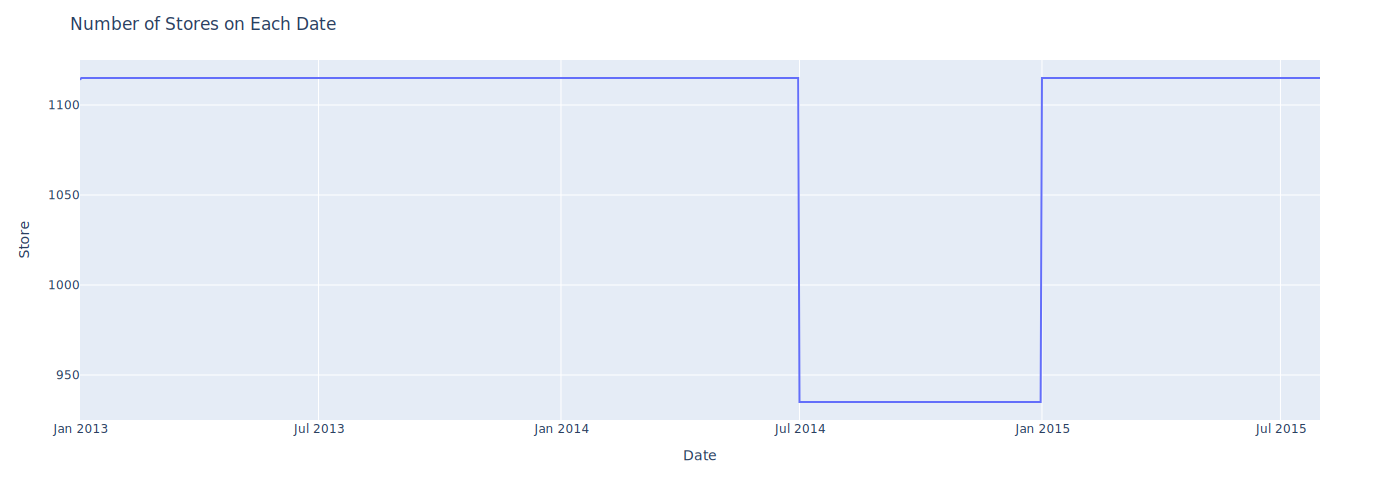

In [73]:
temp = df['train'].group_by('Date').agg(
    pl.col('Store').n_unique()
).sort('Date')

fig = px.line(
    temp,
    x = 'Date',
    y = 'Store'
)

fig.update_layout(title = 'Number of Stores on Each Date', width = 1400)
fig.show()

Turns out there are actually missing stores between 1 Jul 2014 and 31 Dec 2014 (inclusive), it's not detected earlier because those rows literally don't exist

There are only 935 active stores out of 1115 stores during that period, we will try to add and fill the data for the missing stores

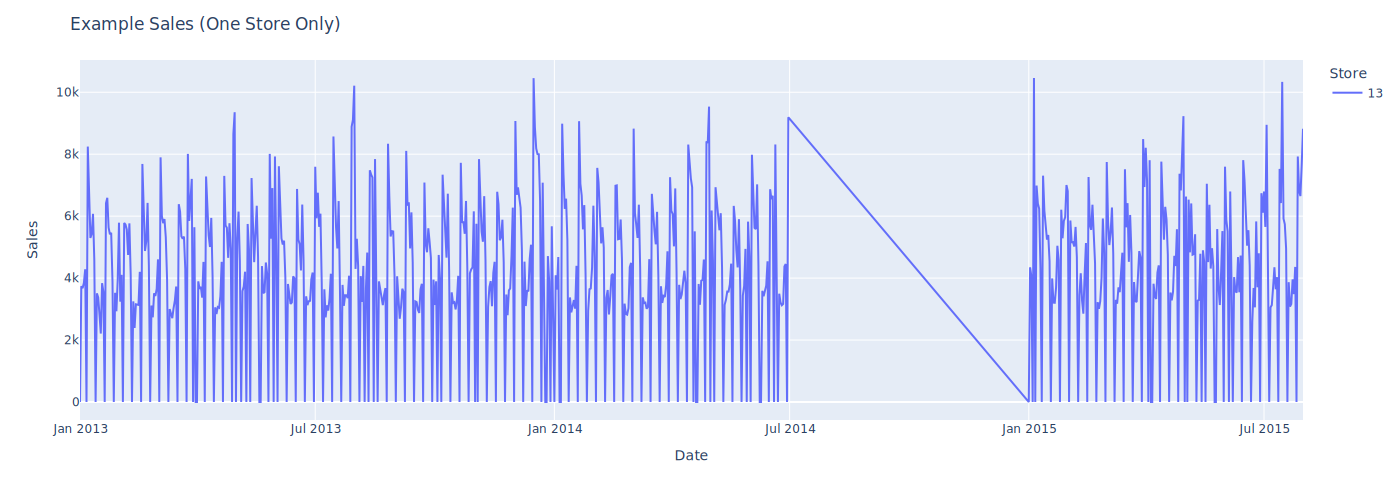

In [74]:
# Give label to each row on the dataframe
# True if the store is missing on 1 July, false otherwise
missing_stores = pl.col('Store').is_in(
    pl.col('Store').filter(pl.col('Date') == pl.date(2014, 7, 1))
).not_()
# Get the unique store ids only instead of all rows
missing_stores = pl.col('Store').filter(missing_stores).unique()

# Visualize the sales on one store
# To be compared with after-fill later
temp = df['train'].filter(
    pl.col('Store') == missing_stores.first()
).sort('Date')

fig = px.line(
    temp,
    x = 'Date',
    y = 'Sales',
    color = 'Store'
)

fig.update_layout(title = 'Example Sales (One Store Only)', width = 1400)
fig.show()

Okay, so to fix them all, the first thing we need to do is create the missing `Date` and `Store` column

In [75]:
# xxx.repeat_by() = repeat in a single row
# pl.repeat(xxx) = repeat as separate rows

temp = df['train'].select(
    # Create 184 missing date rows
    pl.date_range(
        pl.date(2014, 7, 1),
        pl.date(2014, 12, 31),
        '1d'
    # Repeat 180 times for each row (as list)
    # 180 represents the missing stores on each date
    ).repeat_by(missing_stores.count()).alias('Date'),

    pl.repeat(
        # Compress the store ids as list in a single row
        missing_stores.implode(),
        # Repeat the row 184 times
        pl.date_range(
            pl.date(2014, 7, 1),
            pl.date(2014, 12, 31) + pl.duration(days = 1),
            '1d'
        ).diff().dt.total_days().sum()
    ).alias('Store')
)

# Preview for now, but we will explode them all later
# Explode will make each list element as it's own row
temp

Date,Store
list[date],list[i64]
"[2014-07-01, 2014-07-01, … 2014-07-01]","[13, 20, … 1109]"
"[2014-07-02, 2014-07-02, … 2014-07-02]","[13, 20, … 1109]"
"[2014-07-03, 2014-07-03, … 2014-07-03]","[13, 20, … 1109]"
"[2014-07-04, 2014-07-04, … 2014-07-04]","[13, 20, … 1109]"
"[2014-07-05, 2014-07-05, … 2014-07-05]","[13, 20, … 1109]"
…,…
"[2014-12-27, 2014-12-27, … 2014-12-27]","[13, 20, … 1109]"
"[2014-12-28, 2014-12-28, … 2014-12-28]","[13, 20, … 1109]"
"[2014-12-29, 2014-12-29, … 2014-12-29]","[13, 20, … 1109]"


We will also need to get store specific values first (constant value that we can't fill via mean/median)

In [76]:
cols = [
    'StoreType', 'Assortment',
    'PromoInterval', 'Promo2SinceDate',
    'CompetitionDistance', 'CompetitionOpenSinceDate', 'CompetitionOpen'
]

temp2 = df['train']. \
    filter(pl.col('Date') < pl.date(2014, 7, 1)). \
    sort(pl.col('Date')). \
    group_by(pl.col('Store')).agg(
        pl.col(cols).last()
    )

temp2

Store,StoreType,Assortment,PromoInterval,Promo2SinceDate,CompetitionDistance,CompetitionOpenSinceDate,CompetitionOpen
i64,str,str,str,date,f64,date,i32
816,"""c""","""Extended""","""None""",0001-01-01,460.0,0001-01-01,0
926,"""d""","""Extended""","""Jan,Apr,Jul,Oct""",2010-04-01,5150.0,2011-03-01,1
1078,"""d""","""Extended""","""Jan,Apr,Jul,Oct""",2011-10-01,670.0,0001-01-01,0
819,"""a""","""Extended""","""None""",0001-01-01,720.0,2014-10-01,0
137,"""a""","""Basic""","""Jan,Apr,Jul,Oct""",2014-10-01,1730.0,2015-07-01,0
…,…,…,…,…,…,…,…
259,"""b""","""Extra""","""None""",0001-01-01,210.0,0001-01-01,0
357,"""a""","""Basic""","""None""",0001-01-01,2060.0,2008-10-01,1
750,"""d""","""Basic""","""Jan,Apr,Jul,Oct""",2011-04-01,8670.0,2002-02-01,1


Then join the previous 2 dataframes (date, store, and store specific columns)

In [77]:
# 33,120 rows = 180 * 184 (after explosion)
temp = temp.explode(pl.all()).join(
    temp2,
    on = 'Store',
    how = 'left'
)

temp

Date,Store,StoreType,Assortment,PromoInterval,Promo2SinceDate,CompetitionDistance,CompetitionOpenSinceDate,CompetitionOpen
date,i64,str,str,str,date,f64,date,i32
2014-07-01,13,"""d""","""Basic""","""Feb,May,Aug,Nov""",2009-12-01,310.0,0001-01-01,0
2014-07-01,20,"""d""","""Basic""","""Jan,Apr,Jul,Oct""",2014-10-01,2340.0,2009-05-01,1
2014-07-01,22,"""a""","""Basic""","""Jan,Apr,Jul,Oct""",2012-06-01,1040.0,0001-01-01,0
2014-07-01,32,"""a""","""Basic""","""Feb,May,Aug,Nov""",2009-12-01,2910.0,0001-01-01,0
2014-07-01,36,"""a""","""Extended""","""Jan,Apr,Jul,Oct""",2014-10-01,540.0,2003-06-01,1
…,…,…,…,…,…,…,…,…
2014-12-31,1094,"""d""","""Basic""","""Jan,Apr,Jul,Oct""",2014-10-01,2380.0,2013-03-01,1
2014-12-31,1102,"""a""","""Basic""","""Jan,Apr,Jul,Oct""",2014-10-01,850.0,2012-11-01,1
2014-12-31,1104,"""d""","""Basic""","""Jan,Apr,Jul,Oct""",2011-04-01,260.0,2012-02-01,1


Merge the result above to the original (train) dataframe, so now each missing date has a row representation

In [78]:
df['train'] = pl.concat(
    [ df['train'], temp ],
    how = 'diagonal_relaxed'
)

df['train']

Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,Year,Month,DayOfMonth,DayOfYear,WeekOfYear,Season,StoreType,Assortment,PromoInterval,Promo2SinceDate,CompetitionDistance,CompetitionOpenSinceDate,CompetitionOpen
i64,i64,date,i64,i64,i64,i64,str,i64,i32,i8,i8,i16,i8,str,str,str,str,date,f64,date,i32
1,5,2015-07-31,5263,555,1,1,"""None""",1,2015,7,31,212,31,"""Summer""","""c""","""Basic""","""None""",0001-01-01,1270.0,2008-09-01,1
2,5,2015-07-31,6064,625,1,1,"""None""",1,2015,7,31,212,31,"""Summer""","""a""","""Basic""","""Jan,Apr,Jul,Oct""",2010-04-01,570.0,2007-11-01,1
3,5,2015-07-31,8314,821,1,1,"""None""",1,2015,7,31,212,31,"""Summer""","""a""","""Basic""","""Jan,Apr,Jul,Oct""",2011-04-01,14130.0,2006-12-01,1
4,5,2015-07-31,13995,1498,1,1,"""None""",1,2015,7,31,212,31,"""Summer""","""c""","""Extended""","""None""",0001-01-01,620.0,2009-09-01,1
5,5,2015-07-31,4822,559,1,1,"""None""",1,2015,7,31,212,31,"""Summer""","""a""","""Basic""","""None""",0001-01-01,29910.0,2015-04-01,1
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
1094,null,2014-12-31,null,null,null,null,null,null,null,null,null,null,null,null,"""d""","""Basic""","""Jan,Apr,Jul,Oct""",2014-10-01,2380.0,2013-03-01,1
1102,null,2014-12-31,null,null,null,null,null,null,null,null,null,null,null,null,"""a""","""Basic""","""Jan,Apr,Jul,Oct""",2014-10-01,850.0,2012-11-01,1
1104,null,2014-12-31,null,null,null,null,null,null,null,null,null,null,null,null,"""d""","""Basic""","""Jan,Apr,Jul,Oct""",2011-04-01,260.0,2012-02-01,1


Now we just need to fill the remaining null values with median values from other stores (specific to date and store type)

Note that we should only calculate median for one column only (e.g. `Sales`), then fill the rest of columns with whatever value that median store has

If we calculate median on all columns independently (e.g. `Sales` and `Customers`), it will produce wrong result since some column values may be dependent on each other

In [79]:
# We can't use mean since we rely on == operator (equal value)
# Also, mean can be inaccurate if the sales gap between stores are huge

df['train'] = df['train'].with_columns(
    pl.when(
        # If the current sales is the median sales of that day
        pl.col('Sales') == pl.col('Sales').quantile(0.5, 'lower').over(
            [ pl.col('Date'), pl.col('StoreType') ]
        )
    # Then mark that row as true, otherwise false
    ).then(pl.lit(True)).otherwise(pl.lit(False)).alias('IsMedian'),

    # Another helper column, will be filled after this
    pl.lit([]).alias('WasNull')
)

for col in df['train'].select(pl.all().has_nulls()):
    # Skip non-null and helper columns
    if not col.item() or col.name in ['IsMedian', 'WasNull']:
        continue

    df['train'] = df['train'].with_columns(
        # Track column name that was null before filling it
        pl.when(pl.col(col.name).is_null()).then(
            pl.col('WasNull').list.concat(pl.lit(col.name))
        ).otherwise(
            pl.col('WasNull')
        ),

        # Track where the null values will be filled from (the store id)
        pl.lit(None).fill_null(
            pl.col('Store').filter(pl.col('IsMedian')).first()
        ).over(
            [ pl.col('Date'), pl.col('StoreType') ]
        ).alias('FillNullFrom'),

        # Fill null column with column value from the "IsMedian" store
        pl.col(col.name).fill_null(
            pl.col(col.name).filter(pl.col('IsMedian')).first()
        ).over(
            [ pl.col('Date'), pl.col('StoreType') ]
        )
    )

# Check if there's still any null value
print(df['train'].null_count().sum_horizontal().item())

df['train']

0


Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,Year,Month,DayOfMonth,DayOfYear,WeekOfYear,Season,StoreType,Assortment,PromoInterval,Promo2SinceDate,CompetitionDistance,CompetitionOpenSinceDate,CompetitionOpen,IsMedian,WasNull,FillNullFrom
i64,i64,date,i64,i64,i64,i64,str,i64,i32,i8,i8,i16,i8,str,str,str,str,date,f64,date,i32,bool,list[str],i64
1,5,2015-07-31,5263,555,1,1,"""None""",1,2015,7,31,212,31,"""Summer""","""c""","""Basic""","""None""",0001-01-01,1270.0,2008-09-01,1,false,[],627
2,5,2015-07-31,6064,625,1,1,"""None""",1,2015,7,31,212,31,"""Summer""","""a""","""Basic""","""Jan,Apr,Jul,Oct""",2010-04-01,570.0,2007-11-01,1,false,[],391
3,5,2015-07-31,8314,821,1,1,"""None""",1,2015,7,31,212,31,"""Summer""","""a""","""Basic""","""Jan,Apr,Jul,Oct""",2011-04-01,14130.0,2006-12-01,1,false,[],391
4,5,2015-07-31,13995,1498,1,1,"""None""",1,2015,7,31,212,31,"""Summer""","""c""","""Extended""","""None""",0001-01-01,620.0,2009-09-01,1,false,[],627
5,5,2015-07-31,4822,559,1,1,"""None""",1,2015,7,31,212,31,"""Summer""","""a""","""Basic""","""None""",0001-01-01,29910.0,2015-04-01,1,false,[],391
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
1094,3,2014-12-31,4045,352,1,0,"""None""",1,2014,12,31,365,1,"""Winter""","""d""","""Basic""","""Jan,Apr,Jul,Oct""",2014-10-01,2380.0,2013-03-01,1,false,"[""DayOfWeek"", ""Sales"", … ""Season""]",740
1102,3,2014-12-31,3804,408,1,0,"""None""",1,2014,12,31,365,1,"""Winter""","""a""","""Basic""","""Jan,Apr,Jul,Oct""",2014-10-01,850.0,2012-11-01,1,false,"[""DayOfWeek"", ""Sales"", … ""Season""]",3
1104,3,2014-12-31,4045,352,1,0,"""None""",1,2014,12,31,365,1,"""Winter""","""d""","""Basic""","""Jan,Apr,Jul,Oct""",2011-04-01,260.0,2012-02-01,1,false,"[""DayOfWeek"", ""Sales"", … ""Season""]",740


Now that all missing values has been filled, we can visualize again to check the fillings quality

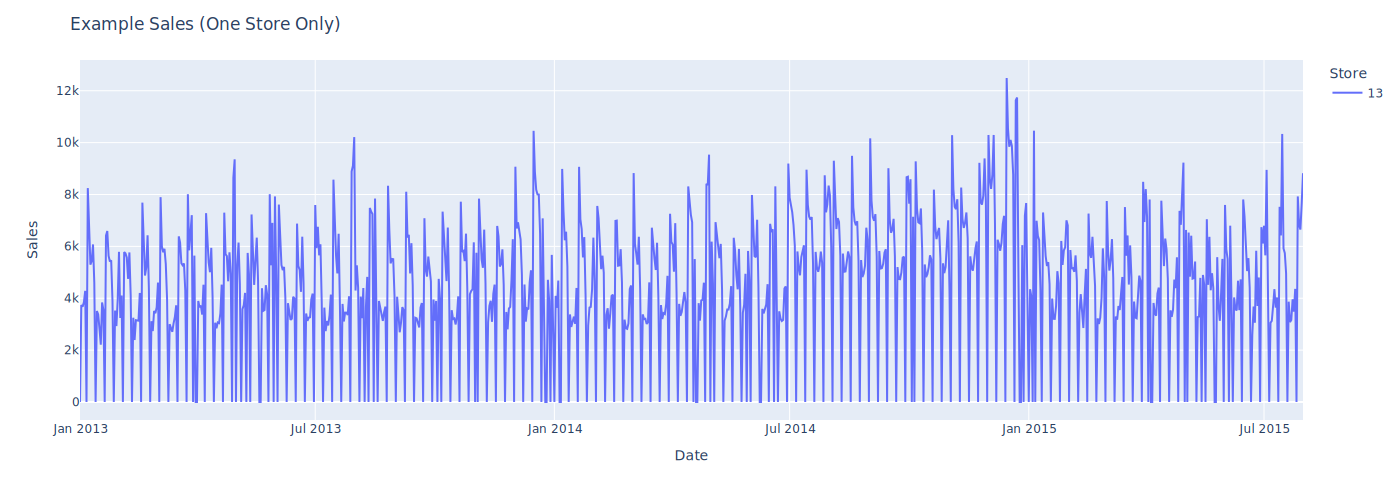

In [80]:
# Example sales on one store
temp = df['train'].filter(
    pl.col('Store') == 13
).sort('Date')

fig = px.line(
    temp,
    x = 'Date',
    y = 'Sales',
    color = 'Store'
)

fig.update_layout(title = 'Example Sales (One Store Only)', width = 1400)
fig.show()

The fillings look quite natural, but if you look between July - Dec 2014, you can notice the values there are higher than the rest

This is probably because the median store of each missing date has overall higher sales than the current store, so the filled null values become higher too

To fix this, we can use the overall sales ratio between the the current and median store, and multiply the filled value by that ratio (similar to [inflation adjustment](https://otexts.com/fpp3/transformations.html#inflation-adjustments))

For example, if the current store has 50% less sales (overall) compared to median store, we will multiply the fillings by 0.5 to normalize it

In [81]:
# Save the overall median sales and customers on each store

temp = df['train'].filter(
    # Exclude the missing date period since it was filled artificially
    (pl.col('Date') < pl.date(2014, 7, 1)) |
    (pl.col('Date') > pl.date(2014, 12, 31)),
    # Filter zero sales since they can skew the median
    pl.col('Sales') != 0
).group_by(pl.col('Store')).agg(
    # No need to use quantile lower anymore
    # We use that earlier since we need to match something
    pl.col('Sales').median().alias('MedSales'),
    pl.col('Customers').median().alias('MedCustomers'),
)

temp

Store,MedSales,MedCustomers
i64,f64,f64
563,5253.5,682.5
21,5231.0,521.0
274,3542.5,913.0
953,5211.0,566.0
676,7134.0,1686.0
…,…,…
387,8811.0,1169.5
1024,6090.0,777.0
244,5018.0,536.0


In [82]:
df['train'] = df['train'].join(
    temp,
    # Add median for the current store
    on = 'Store',
    how = 'inner'
).join(
    temp,
    # Add median for the median store
    left_on = 'FillNullFrom',
    right_on = 'Store',
    suffix = 'From',
    how = 'inner'
)

df['train'].tail()

Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,Year,Month,DayOfMonth,DayOfYear,WeekOfYear,Season,StoreType,Assortment,PromoInterval,Promo2SinceDate,CompetitionDistance,CompetitionOpenSinceDate,CompetitionOpen,IsMedian,WasNull,FillNullFrom,MedSales,MedCustomers,MedSalesFrom,MedCustomersFrom
i64,i64,date,i64,i64,i64,i64,str,i64,i32,i8,i8,i16,i8,str,str,str,str,date,f64,date,i32,bool,list[str],i64,f64,f64,f64,f64
1094,3,2014-12-31,4045,352,1,0,"""None""",1,2014,12,31,365,1,"""Winter""","""d""","""Basic""","""Jan,Apr,Jul,Oct""",2014-10-01,2380.0,2013-03-01,1,false,"[""DayOfWeek"", ""Sales"", … ""Season""]",740,4452.0,362.0,6979.0,511.5
1102,3,2014-12-31,3804,408,1,0,"""None""",1,2014,12,31,365,1,"""Winter""","""a""","""Basic""","""Jan,Apr,Jul,Oct""",2014-10-01,850.0,2012-11-01,1,false,"[""DayOfWeek"", ""Sales"", … ""Season""]",3,6823.5,693.5,6575.0,743.0
1104,3,2014-12-31,4045,352,1,0,"""None""",1,2014,12,31,365,1,"""Winter""","""d""","""Basic""","""Jan,Apr,Jul,Oct""",2011-04-01,260.0,2012-02-01,1,false,"[""DayOfWeek"", ""Sales"", … ""Season""]",740,5452.0,432.0,6979.0,511.5
1107,3,2014-12-31,3804,408,1,0,"""None""",1,2014,12,31,365,1,"""Winter""","""a""","""Basic""","""Jan,Apr,Jul,Oct""",2010-04-01,1400.0,2012-06-01,1,false,"[""DayOfWeek"", ""Sales"", … ""Season""]",3,5719.0,649.0,6575.0,743.0
1109,3,2014-12-31,3825,504,1,0,"""None""",1,2014,12,31,365,1,"""Winter""","""c""","""Basic""","""Jan,Apr,Jul,Oct""",2012-06-01,3490.0,2011-04-01,1,false,"[""DayOfWeek"", ""Sales"", … ""Season""]",730,4568.5,444.5,7805.0,965.0


`MedSales` and `MedCustomers` are the overall median values for the current store

`MedSalesFrom` and `MedCustomersFrom` are the overall median values for the median store

We will use the ratio between `XXX` and `XXXFrom` to normalize the filled values on the current store

In [83]:
# Normalize sales and customers only
df['train'] = df['train'].with_columns(
    pl.when(pl.lit('Sales').is_in(pl.col('WasNull'))).then(
        pl.col('Sales') * pl.col('MedSales') / pl.col('MedSalesFrom')
    ).otherwise(pl.col('Sales')).cast(pl.Int64),

    pl.when(pl.lit('Customers').is_in(pl.col('WasNull'))).then(
        pl.col('Customers') * pl.col('MedCustomers') / pl.col('MedCustomersFrom')
    ).otherwise(pl.col('Customers')).cast(pl.Int64),
)

# Check null count
print(df['train'].null_count().sum_horizontal().item())

# Check nan and infinite in case of weird division error
col = pl.selectors.integer() | pl.selectors.float()
print(df['train'].select(col.is_nan().sum()).sum_horizontal().item())
print(df['train'].select(col.is_infinite().sum()).sum_horizontal().item())

df['train'].tail()

0
0
0


Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,Year,Month,DayOfMonth,DayOfYear,WeekOfYear,Season,StoreType,Assortment,PromoInterval,Promo2SinceDate,CompetitionDistance,CompetitionOpenSinceDate,CompetitionOpen,IsMedian,WasNull,FillNullFrom,MedSales,MedCustomers,MedSalesFrom,MedCustomersFrom
i64,i64,date,i64,i64,i64,i64,str,i64,i32,i8,i8,i16,i8,str,str,str,str,date,f64,date,i32,bool,list[str],i64,f64,f64,f64,f64
1094,3,2014-12-31,2580,249,1,0,"""None""",1,2014,12,31,365,1,"""Winter""","""d""","""Basic""","""Jan,Apr,Jul,Oct""",2014-10-01,2380.0,2013-03-01,1,false,"[""DayOfWeek"", ""Sales"", … ""Season""]",740,4452.0,362.0,6979.0,511.5
1102,3,2014-12-31,3947,380,1,0,"""None""",1,2014,12,31,365,1,"""Winter""","""a""","""Basic""","""Jan,Apr,Jul,Oct""",2014-10-01,850.0,2012-11-01,1,false,"[""DayOfWeek"", ""Sales"", … ""Season""]",3,6823.5,693.5,6575.0,743.0
1104,3,2014-12-31,3159,297,1,0,"""None""",1,2014,12,31,365,1,"""Winter""","""d""","""Basic""","""Jan,Apr,Jul,Oct""",2011-04-01,260.0,2012-02-01,1,false,"[""DayOfWeek"", ""Sales"", … ""Season""]",740,5452.0,432.0,6979.0,511.5
1107,3,2014-12-31,3308,356,1,0,"""None""",1,2014,12,31,365,1,"""Winter""","""a""","""Basic""","""Jan,Apr,Jul,Oct""",2010-04-01,1400.0,2012-06-01,1,false,"[""DayOfWeek"", ""Sales"", … ""Season""]",3,5719.0,649.0,6575.0,743.0
1109,3,2014-12-31,2238,232,1,0,"""None""",1,2014,12,31,365,1,"""Winter""","""c""","""Basic""","""Jan,Apr,Jul,Oct""",2012-06-01,3490.0,2011-04-01,1,false,"[""DayOfWeek"", ""Sales"", … ""Season""]",730,4568.5,444.5,7805.0,965.0


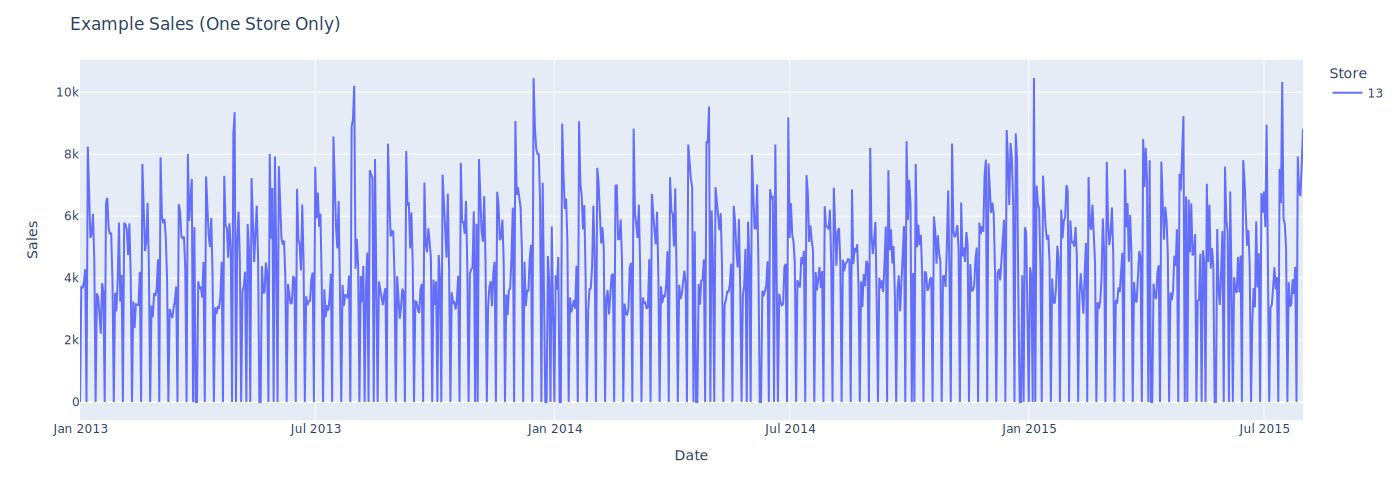

In [84]:
# Example sales on one store
temp = df['train'].filter(
    pl.col('Store') == 13
).sort('Date')

fig = px.line(
    temp,
    x = 'Date',
    y = 'Sales',
    color = 'Store'
)

fig.update_layout(title = 'Example Sales (One Store Only)', width = 1400)
fig.show()

Nice, the fillings look pretty natural now. Let's filter the zero sales (temporarily) to make it easier to look at the pattern

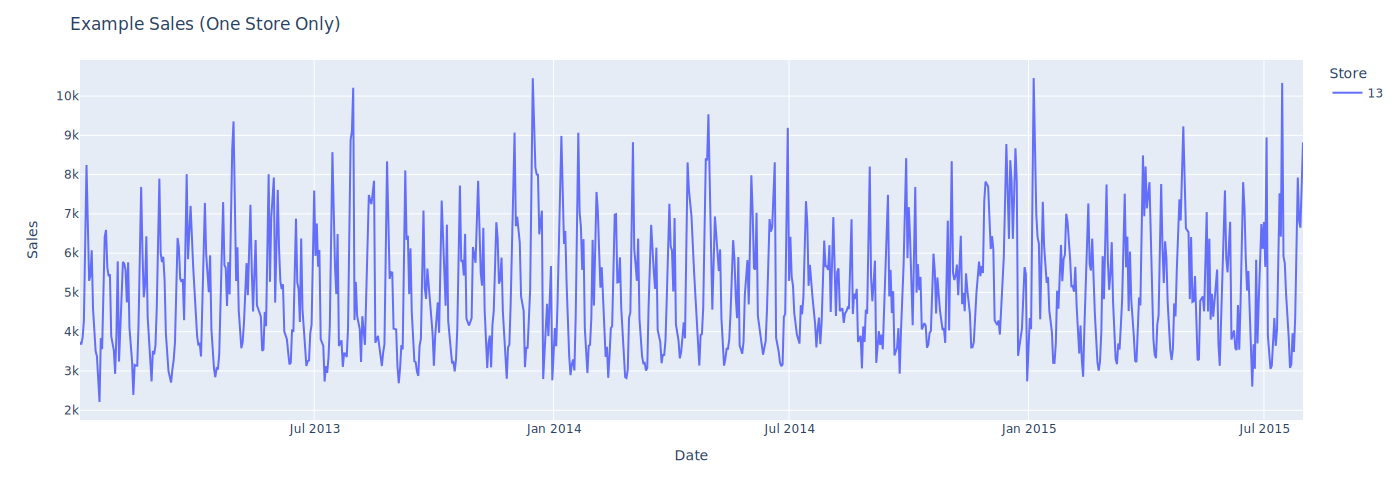

In [85]:
fig = px.line(
    temp.filter(pl.col('Sales') != 0),
    x = 'Date',
    y = 'Sales',
    color = 'Store'
)

fig.update_layout(title = 'Example Sales (One Store Only)', width = 1400)
fig.show()

While it looks good on the eyes, be cautious when removing zero sales, as it will introduce missing dates/rows again

On models like ARIMA, where the forecast result at time $t$ ($y_t$) depends directly  on the values of the previous $t-p$ days ($y_{t-1}, y_{t-2}, ..., y_{t-p}$), missing dates will surely cause problem

However, for non-time based models like normal regression and neural network, the model will simply be fitted with less data points since it uses $x$ (columns) instead of $y$ (previous values)

## Exploratory Data Analysis

In [86]:
# Drop the temporary columns first
df['train'] = df['train'].drop([
    'IsMedian', 'WasNull', 'FillNullFrom',
    'MedSales', 'MedCustomers',
    'MedSalesFrom', 'MedCustomersFrom'
], strict = False)

df['train'].head(1)

Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,Year,Month,DayOfMonth,DayOfYear,WeekOfYear,Season,StoreType,Assortment,PromoInterval,Promo2SinceDate,CompetitionDistance,CompetitionOpenSinceDate,CompetitionOpen
i64,i64,date,i64,i64,i64,i64,str,i64,i32,i8,i8,i16,i8,str,str,str,str,date,f64,date,i32
1,5,2015-07-31,5263,555,1,1,"""None""",1,2015,7,31,212,31,"""Summer""","""c""","""Basic""","""None""",0001-01-01,1270.0,2008-09-01,1


In [87]:
# Don't visualize these columns
cols = ['Store', 'Date', 'Open']
# Invert so we get columns to visualize
cols = [
    col for col in df['train'].columns
    if col not in cols
]

print(len(cols))
print(cols)

19
['DayOfWeek', 'Sales', 'Customers', 'Promo', 'StateHoliday', 'SchoolHoliday', 'Year', 'Month', 'DayOfMonth', 'DayOfYear', 'WeekOfYear', 'Season', 'StoreType', 'Assortment', 'PromoInterval', 'Promo2SinceDate', 'CompetitionDistance', 'CompetitionOpenSinceDate', 'CompetitionOpen']


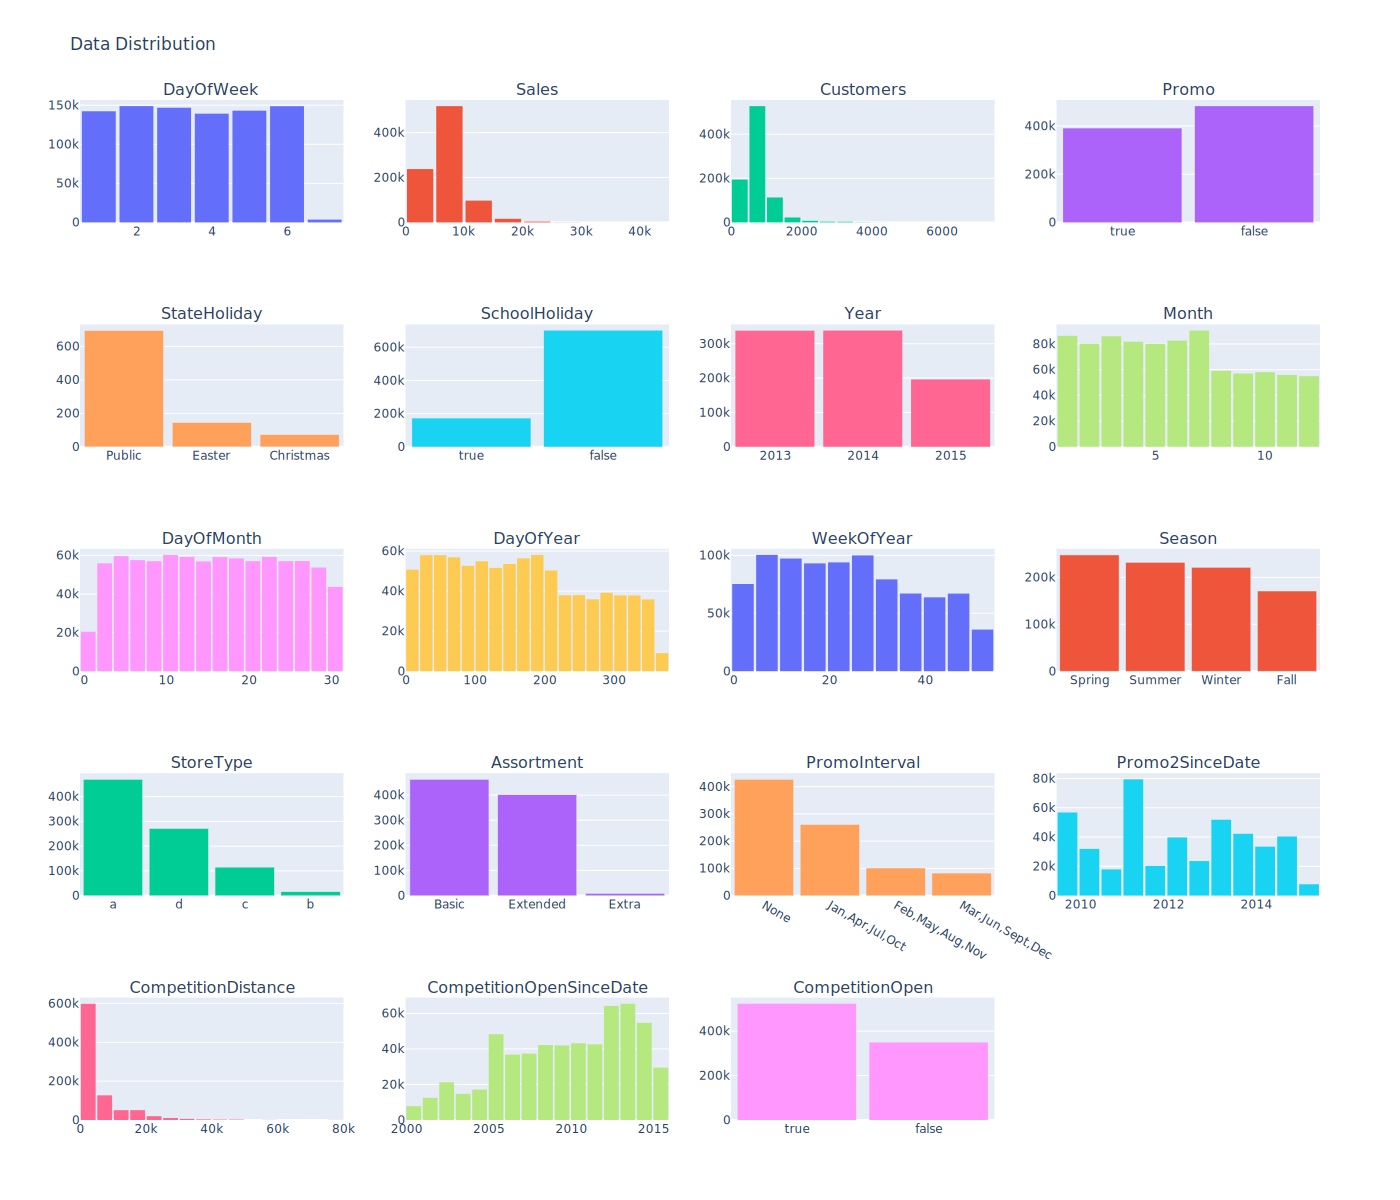

In [88]:
n_rows, n_cols = 5, 4
fig = make_subplots(n_rows, n_cols, subplot_titles = cols)

def top_n_categories(col: pl.Series, top_k = 10):
    # Returns dataframe with 2 columns: value name and value count
    return col.value_counts().top_k(top_k, by = 'count')

for i, name in enumerate(cols):
    irow = i // n_cols + 1
    icol = i % n_cols + 1

    # Custom filters to apply
    col = df['train'].filter(pl.col('Sales') != 0).get_column(name)
    if name in ['Promo2SinceDate', 'CompetitionOpenSinceDate']:
        col = col.filter(col.dt.year() >= 2000)
    elif name in ['StateHoliday']:
        col = col.filter(col != 'None')

    if col.dtype == pl.String:
        col = top_n_categories(col)
        fig.add_bar(
            x = col[name],
            y = col['count'],
            name = name,
            row = irow, col = icol
        )
    else:
        if col.dtype.is_integer() and col.n_unique() == 2:
            col = col.cast(pl.Boolean)

        if col.n_unique() > 20:
            n_bins = 20
        else:
            n_bins = None

        fig.add_histogram(
            x = col,
            nbinsx = n_bins,
            name = name,
            row = irow, col = icol
        )

fig.update_layout(
    title = 'Data Distribution<br>' +
        '<sup>Y-axis is the variable quantity, not sum of sales</sup>',
    bargap = 0.1,
    showlegend = False,
    width = 1400, height = 1200
)

fig.show()

The graphs above are mostly garbage (not that useful), but we can use it to do further analysis like:
- Most stores don't open on Sunday. Is it store specific or defined by other factors (e.g. store type)?
- Are assortment and promo interval specific per store, or defined by store type too?
- Is promo only for special occasions only (non-recurring promos), or does it include all kinds of promos?
- The sales and customers don't give any valuable info, we may need to see if some stores have similar patterns, and are they related to store type too?
- Holiday, promo, and competitor are defined by a simple boolen value. Can the model realize this or should we do something on our part?
- And so on...

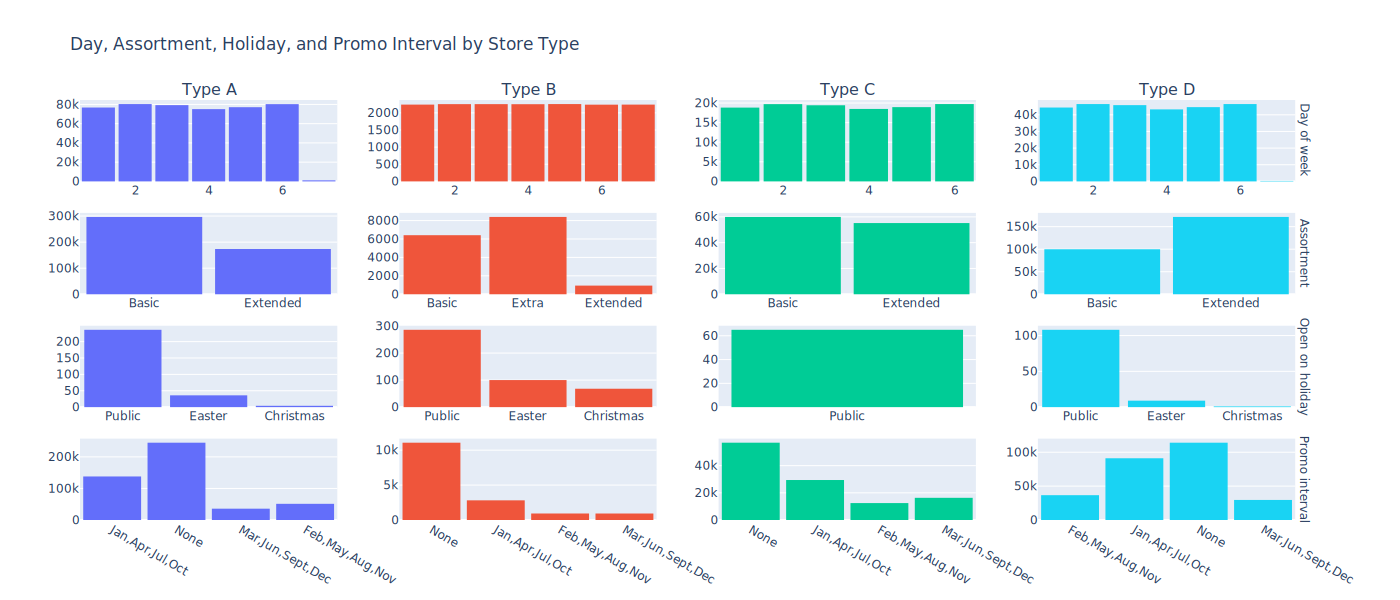

In [89]:
col_titles = ['Type A', 'Type B', 'Type C', 'Type D']
row_titles = ['Day of week', 'Assortment', 'Open on holiday', 'Promo interval']

# https://plotly.com/python/discrete-color/
color = ['#636EFA', '#EF553B', '#00CC96', '#19D3F3', '#FF6692', '#FFFF33']

fig = make_subplots(
    rows = 4, cols = 4,
    column_titles = col_titles,
    row_titles = row_titles
)

for i, store in enumerate(['a', 'b', 'c', 'd']):
    temp = df['train'].filter(
        pl.col('Sales') != 0,
        pl.col('StoreType') == store
    ).sort(pl.col('StoreType'))

    for j, col in enumerate(['DayOfWeek', 'Assortment', 'PromoInterval']):
        fig.add_histogram(
            x = temp[col],
            marker_color = color[i],
            row = j + 1 if j != 2 else j + 2, col = i + 1
        )

    fig.add_histogram(
        x = temp.filter(
            pl.col('Sales') != 0,
            pl.col('StateHoliday') != 'None'
        )['StateHoliday'],
        marker_color = color[i],
        row = 3, col = i + 1
    )

# Prevent overlapping promo interval text
for i in range(len(fig['layout']['annotations'])):
    if fig['layout']['annotations'][i]['text'] not in col_titles:
        fig['layout']['annotations'][i]['font']['size'] = 12

fig.update_layout(
    title = 'Day, Assortment, Holiday, and Promo Interval by Store Type<br>' +
        '<sup>Y-axis is the variable quantity, not sum of sales</sup>',
    bargap = 0.1,
    showlegend = False,
    width = 1400, height = 600
)

fig.show()

Most store types don't open on Sunday (day 7), except for store type B, which seems to open on most holidays too

We can also see that promo interval is independent of store type. This may affect the sales pattern, let's see further

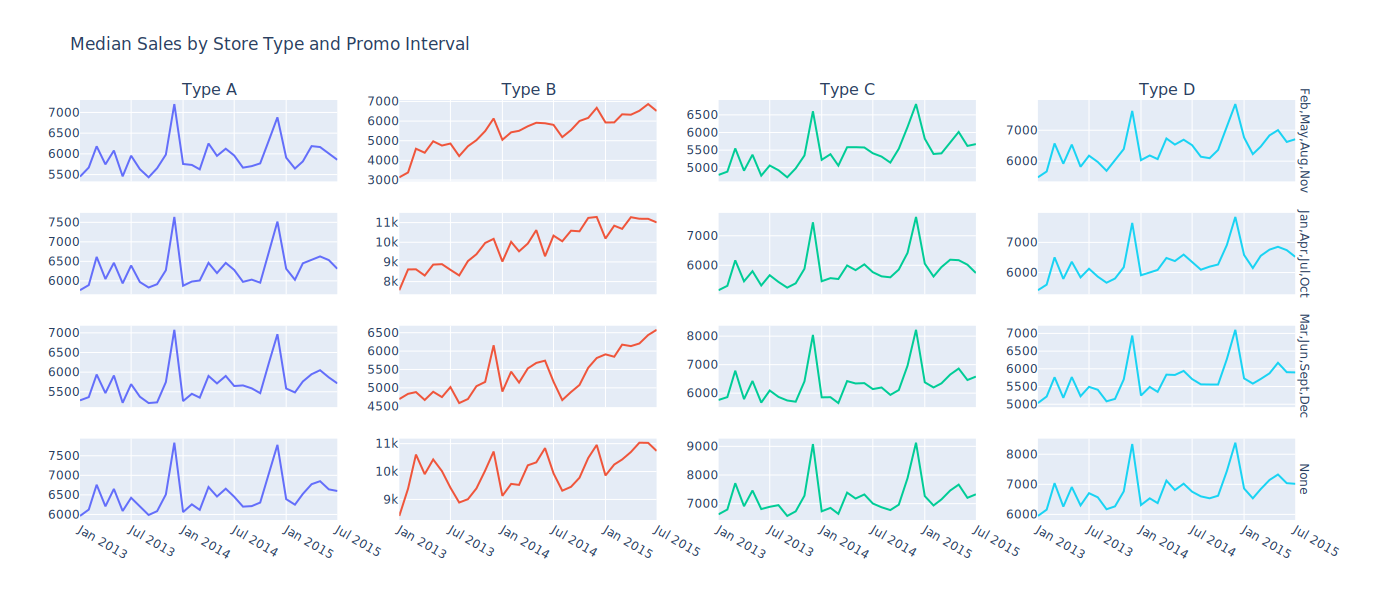

In [90]:
col_titles = ['Type A', 'Type B', 'Type C', 'Type D']
row_titles = temp['PromoInterval'].unique().sort().to_list()

# https://plotly.com/python/discrete-color/
color = ['#636EFA', '#EF553B', '#00CC96', '#19D3F3', '#FF6692', '#FFFF33']

fig = make_subplots(
    rows = 4, cols = 4,
    column_titles = col_titles,
    row_titles = row_titles,
    shared_xaxes = True
)

for i, store in enumerate(['a', 'b', 'c', 'd']):
    temp = df['train'].filter(
        pl.col('Sales') != 0,
        pl.col('StoreType') == store
    ).sort(pl.col('StoreType'))

    for j, intrv in enumerate(row_titles):
        # Aggregate by monthly sales only for easier viewing
        temp2 = temp.filter(pl.col('PromoInterval') == intrv). \
            group_by(['Year', 'Month', 'StoreType']).agg(pl.col('Sales').median()). \
            sort(['Year', 'Month'])

        temp2 = temp2.with_columns(
            pl.date(pl.col('Year'), pl.col('Month'), pl.lit(1)).alias('Date')
        )

        fig.add_scatter(
            x = temp2['Date'],
            y = temp2['Sales'],
            marker_color = color[i],
            row = j + 1, col = i + 1
        )

# Prevent overlapping promo interval text
for i in range(len(fig['layout']['annotations'])):
    if fig['layout']['annotations'][i]['text'] not in col_titles:
        fig['layout']['annotations'][i]['font']['size'] = 12

fig.update_layout(
    title = 'Median Sales by Store Type and Promo Interval',
    showlegend = False,
    width = 1400, height = 600
)

fig.show()

It seems that all stores have similar sales pattern, except for store type B

I think we can group/cluster store type A, C, and D as one category later, but maybe separate store type B as its own category

TODO: Is the anomaly on store type B purely because of they open on Sunday and holidays? What makes them grow faster than the rest?

---

Next, we will focus on promo, holiday, and competition effect on few select stores (randomly selected)

Each of these stores will represent their store type. We don't use "group by" aggregation since it may hide the characteristic of individual store

In [91]:
df['train'].sample(fraction = 1, shuffle = True, seed = 11). \
    filter(pl.col('CompetitionOpenSinceDate') > pl.date(2013, 1, 1)). \
    group_by(pl.col('StoreType')).first().sort(pl.col('StoreType'))

StoreType,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,Year,Month,DayOfMonth,DayOfYear,WeekOfYear,Season,Assortment,PromoInterval,Promo2SinceDate,CompetitionDistance,CompetitionOpenSinceDate,CompetitionOpen
str,i64,i64,date,i64,i64,i64,i64,str,i64,i32,i8,i8,i16,i8,str,str,str,date,f64,date,i32
"""a""",380,5,2014-01-17,10199,1146,1,0,"""None""",0,2014,1,17,17,3,"""Winter""","""Basic""","""Mar,Jun,Sept,Dec""",2014-03-01,2240.0,2013-05-01,1
"""b""",423,3,2013-05-08,11872,2284,1,0,"""None""",0,2013,5,8,128,19,"""Spring""","""Basic""","""None""",0001-01-01,1270.0,2014-05-01,0
"""c""",598,3,2013-10-23,6003,775,1,1,"""None""",0,2013,10,23,296,43,"""Fall""","""Basic""","""Jan,Apr,Jul,Oct""",2014-10-01,550.0,2013-12-01,0
"""d""",800,3,2013-12-25,0,0,0,0,"""Christmas""",1,2013,12,25,359,52,"""Winter""","""Basic""","""None""",0001-01-01,2020.0,2014-07-01,0


In [92]:
# https://plotly.com/python/discrete-color/
color = ['#636EFA', '#EF553B', '#00CC96', '#19D3F3', '#FF6692', '#FFFF33']

fig = make_subplots(
    rows = 4, cols = 1,
    row_titles = ['Store 380', 'Store 423', 'Store 598', 'Store 800'],
    shared_xaxes = True
)

for i, store in enumerate([380, 423, 598, 800]):
    temp = df['train'].filter(pl.col('Store') == store).sort('Date')

    fig.add_scatter(
        x = temp['Date'],
        y = temp['Sales'],
        opacity = 0.2, marker_color = color[0], # Purple
        hovertemplate = 'Sales: $%{y:.0f}',
        row = i + 1, col = 1
    )

    temp2 = temp.filter(pl.col('Promo') == 0)

    fig.add_scatter(
        x = temp2['Date'],
        y = temp2['Sales'],
        mode = 'markers', marker_color = color[1], # Red
        hovertemplate = 'Promo day',
        row = i + 1, col = 1
    )

    temp2 = temp.filter(pl.col('Promo') == 1)

    fig.add_scatter(
        x = temp2['Date'],
        y = temp2['Sales'],
        mode = 'markers', marker_color = color[2], # Green
        hovertemplate = 'Non-promo day',
        row = i + 1, col = 1
    )

    temp2 = temp.filter(pl.col('StateHoliday') != 'None')

    fig.add_bar(
        x = temp2['Date'],
        y = [ temp['Sales'].max() for _ in range(len(temp2)) ],
        marker_color = color[3], # Cyan
        customdata = temp2.select('StateHoliday'),
        hovertemplate = '%{customdata[0]} holiday',
        row = i + 1, col = 1
    )

    temp2 = temp.filter(pl.col('Date') == pl.col('CompetitionOpenSinceDate'))

    fig.add_bar(
        x = temp2['Date'],
        y = [ temp['Sales'].max() for _ in range(len(temp2)) ],
        marker_color = color[4], # Pink
        hovertemplate = 'Competition opened',
        row = i + 1, col = 1
    )

    fig.add_scatter(
        x = temp['Date'],
        y = temp['Sales'].rolling_mean(30),
        opacity = 0.75, marker_color = color[5], # Yellow
        hovertemplate = 'Sales MA: $%{y:.0f}',
        row = i + 1, col = 1
    )

subtitle = [
    'Green = promo day, ', 'red = non-promo day, ',
    'cyan = holiday, ', 'pink = competition opened, ',
    'yellow = rolling mean (30 days)'
]

fig.update_layout(
    title = f'Sales Pattern on Observed Stores<br><sup>{''.join(subtitle)}</sup>',
    hovermode = 'x unified',
    barmode = 'overlay',
    showlegend = False,
    width = 1400,
    height = 1000
)

fig.update_xaxes(
    # Zoom to last 1 year only by default
    range = ['2014-07-01', '2015-07-31'],
    minor_dtick = 'M1',
    minor_ticklen = 4
)

# Make it interactive for easier analysis
fig.show(renderer = 'notebook_connected')

It seems that these stores always have a full week promo every two weeks, so it becomes a recurring pattern rather than a special occasion

The mean of sales (yellow line) also seems to be relatively stable on each month of the year, as sales drop is compensated by sales spike on the next week

The stability of the mean throughout the year may be a sign that this time series is (weakly) stationary

---

These stores also don't open on holidays, including major ones like Christmas (25 Dec) and Easter day (early April), except for store 423 (store type B)

Store 423 seems to have specific promo on each Easter day, but not on Christmas day. Other stores don't have promo on Easter nor Christmas at all (and they're closed)

Due to this, on stores that don't open on holiday, we can usually see sales spike 2 days (23 Dec) before Christmas rather than on Christmas day itself

Since store 423 is open on holiday, sales spike can usually be seen on the actual holiday day, but doesn't always have lead/lag effect on other stores (except on Christmas)

---

Lastly, competition effect seems hard to detect with naked eyes so there's not much to see, but this [notebook](https://www.kaggle.com/code/ggep22/how-does-new-competition-affect-sales) shows slight sales drop after a competitor opened

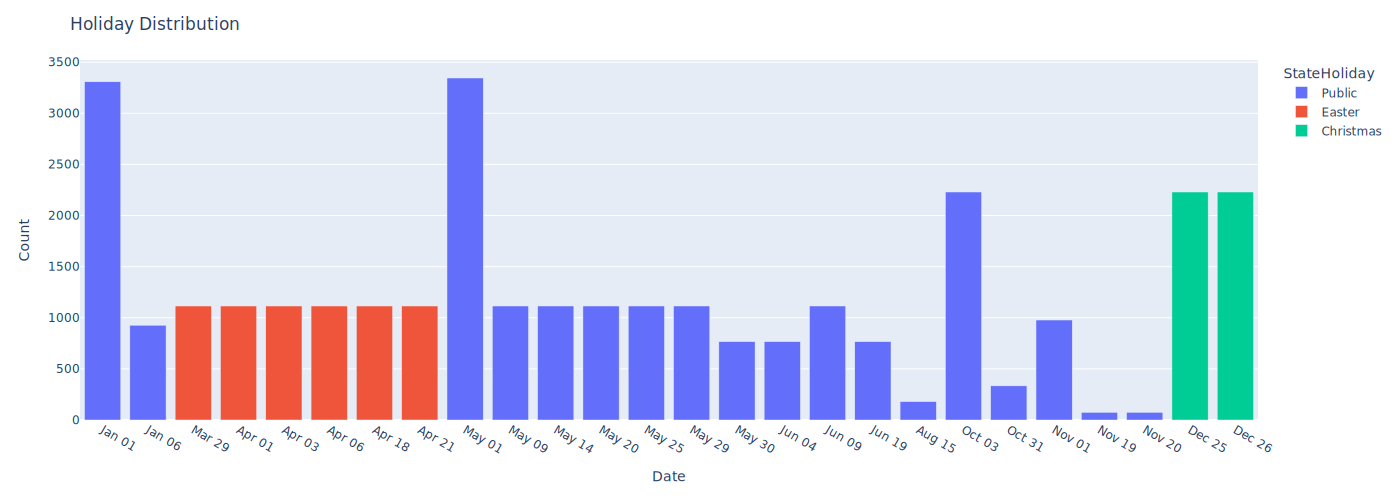

In [93]:
temp = df['train'].filter(pl.col('StateHoliday') != 'None'). \
    with_columns(
        pl.date(
            pl.lit(1),
            pl.col('Month'),
            pl.col('DayOfMonth')
        ).dt.strftime('%b %d').alias('Date')
    ).sort(
        pl.col('Month'),
        pl.col('DayOfMonth')
    ).group_by('Date', maintain_order = True).agg(
        pl.col('StateHoliday').mode().first(),
        pl.col('StateHoliday').len().alias('Count')
    )

fig = px.bar(
    temp,
    x = 'Date',
    y = 'Count',
    color = 'StateHoliday'
)

fig.update_layout(title = 'Holiday Distribution', width = 1400)

fig.update_xaxes(
    type = 'category',
    categoryorder = 'array',
    categoryarray = temp['Date'].to_list()
)

fig.show()

By comparing the sales on previous graph with holiday on this graph:
- 1 Jan (new year): barely has any effect on sales, overshadowed by Christmas
- 1 May (labour day): peak on the actual day (store type B), slightly peaked on the days before (non-type B)
- 3 Oct (unity day): peak on the actual day (store type B), normal on the days before (non-type B)
- Other holidays that I checked also has peak on the actual day (type B)

It seems that Christmas is the only holiday that has a lag effect on non-type B stores, confirming our previous hypothesis

TODO: Search if there is a statistical method to automatically find holiday lag effect, so we don't need manual observation

In [94]:
for name in ['train', 'test']:
    df[name] = df[name].with_columns(
        # Mark 23 Dec as Chrismas holiday too, since sales spike usually happens
        # Other holidays don't have a lag effect so it's safe to leave them as generic public holiday
        pl.when(pl.col('Month') == 12, pl.col('DayOfMonth') == 23).\
            then(pl.lit('Christmas')).otherwise(pl.col('StateHoliday')). \
            alias('StateHoliday')
    )

## Pre-Modeling & SARIMA

I originally wanted to use neural network such as LSTM to make the prediction, but changed my mind and decided to learn SARIMA(X) instead

Thus, we will only use a few columns as opposed of all the extra columns that we engineered previously, sorry

---

Classical models like ARIMA assume that all [time series are composed of multiple components](https://otexts.com/fpp3/components.html), such as trend (general direction), seasonality (cyclical behavior), and the residual (error/noise)

Mathematically, this is written as $y_t = T_t + S_t + R_t$ for additive time series, or $y_t = T_t * S_t * R_t$ for multiplicative time series (where $y_t$ = result at time $t$, $T_t$ = trend at time $t$, and so on)

In order to make stable and accurate predictions of $y_t$, we need to identify each of these components correctly, especially the seasonal period

---

STL ([ref 1](https://otexts.com/fpp3/stl.html), [ref 2](https://nixtlaverse.nixtla.io/statsforecast/docs/models/multipleseasonaltrend.html)) is a commonly used method for decomposing a time series into its individual component ($T_t$, $S_t$, and $R_t$), assuming that seasonality exists on the time series

With STL, we can also visually check the characteristic of the time series, and whether it's stationary or not (stationarity is another important factor in time series modeling)

We will start by plotting STL for store type B first, then store type A, C, D combined after that

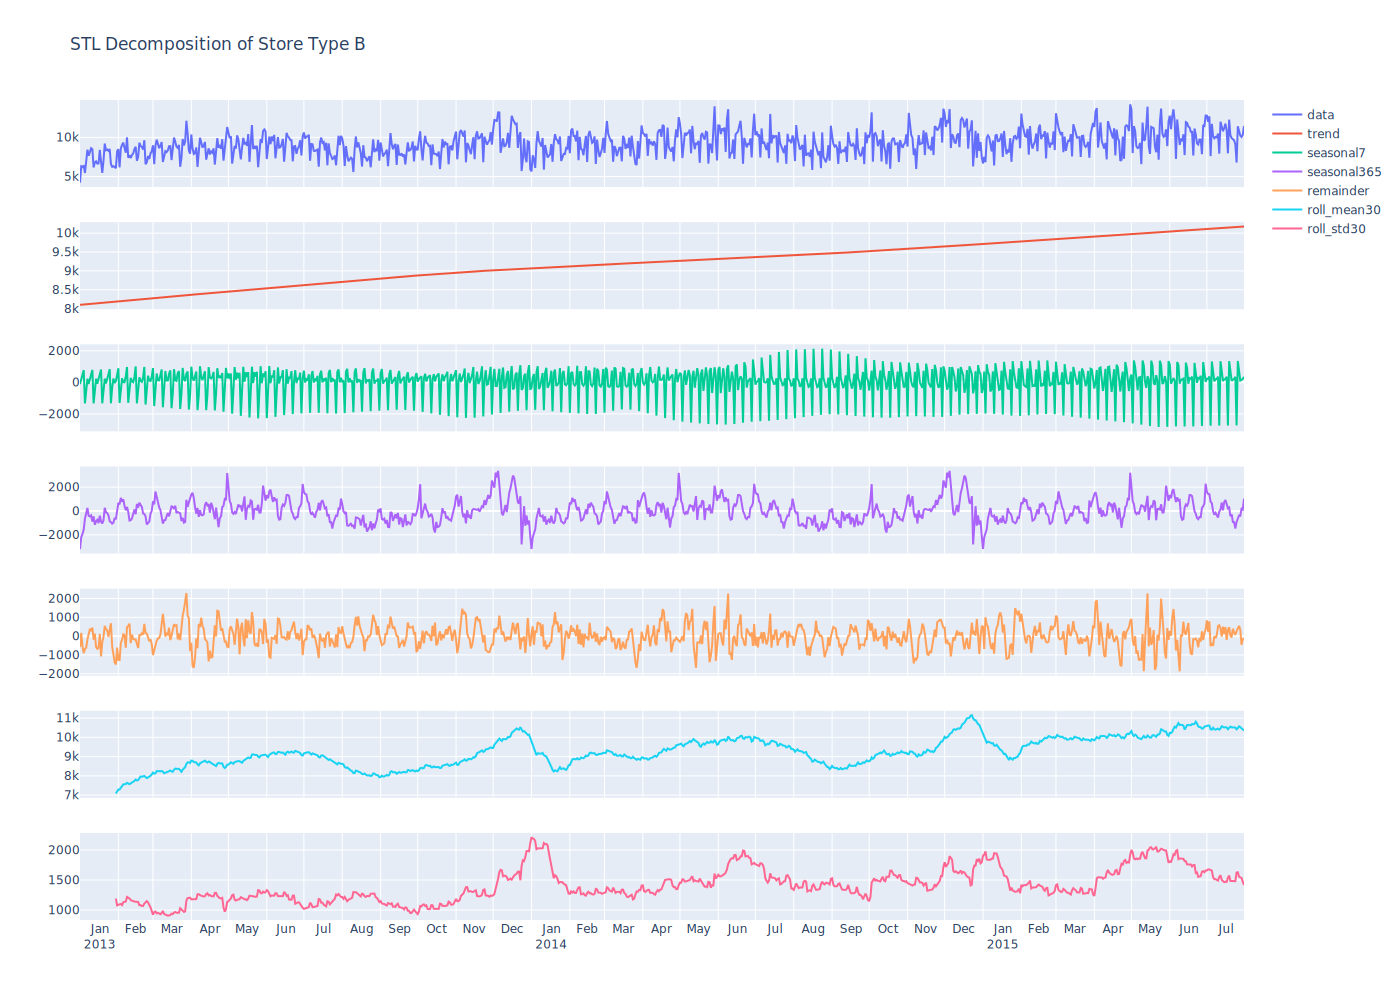

In [95]:
# Median is used since mean can hide the influence of small stores
temp = df['train'].filter(pl.col('StoreType') == 'b'). \
    group_by('Date').agg(pl.col('Sales').median()). \
    sort('Date')

# Format for StatsForecast (unique_id, ds, y)
temp = temp.rename({'Date': 'ds', 'Sales': 'y'}).with_columns(
    pl.lit(1).alias('unique_id')
)

# Assume there are 2 seasonalities (weekly promo cycle, yearly holiday)
# This means Y = T + S1 + S2 + R instead of Y = T + S + R
models = [ sfm.MSTL(season_length = [7, 365]) ]
sf = StatsForecast(models = models, freq = '1d', n_jobs = -1)

result = sf.fit(temp)
result = result.fitted_[0, 0].model_
cols = [
    *result.columns,
    temp['y'].rolling_mean(30).alias('roll_mean30'),
    temp['y'].rolling_std(30).alias('roll_std30')
]

fig = make_subplots(rows = len(cols), cols = 1, shared_xaxes = True)

for i, col in enumerate(cols):
    fig.add_scatter(
        y = result[col] if type(col) is str else col,
        x = temp['ds'],
        name = col if type(col) is str else col.name,
        row = i + 1, col = 1
    )

fig.update_layout(
    title = 'STL Decomposition of Store Type B<br>' +
        '<sup>From sales perspective only (median), not customers</sup>',
    width = 1400,
    height = 1000
)

fig.update_xaxes(
    dtick = 'M1',
    tickformat = '%b\n%Y',
    ticklabelmode = 'period'
)

fig.show()

Though I don't know the math behind STL, seasonality usually can be said as the value after removing the trend, and residual (remainder) as the value after removing the trend and seasonality

Using weekly and yearly seasonalities ($y_t = T_t + S1_t + S2_t + R_t$) seems to yield a good result, because the residual almost resemble a white noise (random fluctuation with no pattern)

However, we can still see that the residual is not truly random, the variance seems to be higher around March - June each year, so there may be another seasonality we haven't caught yet

---

I also added rolling mean and standard deviation at the end (which are actually not part of STL), to help us see the stationarity of the original data (before being decomposed by STL)

By looking at the last 2 graphs, both the mean and standard deviation seem to be increasing, we can also confirm this by looking on the raw data and weekly seasonality

This means that store type B is not stationary (the statistical properties are changing over time), so we need to normalize it somehow later

---

Before continuing to plot the STL of store type A, C, D (combined), we better check if there's truly any hidden seasonalities left, or if we got the wrong seasonalities

We can do this with the help of Fourier transformation ([ref 1](https://ataspinar.com/posts/time-series-forecasting-with-stochastic-signal-analysis-techniques/), [ref 2](https://towardsdatascience.com/how-to-find-seasonality-patterns-in-time-series-c3b9f11e89c6/)), and by plotting the [autocorrelation](https://otexts.com/fpp3/acf.html) (ACF) of the STL residual

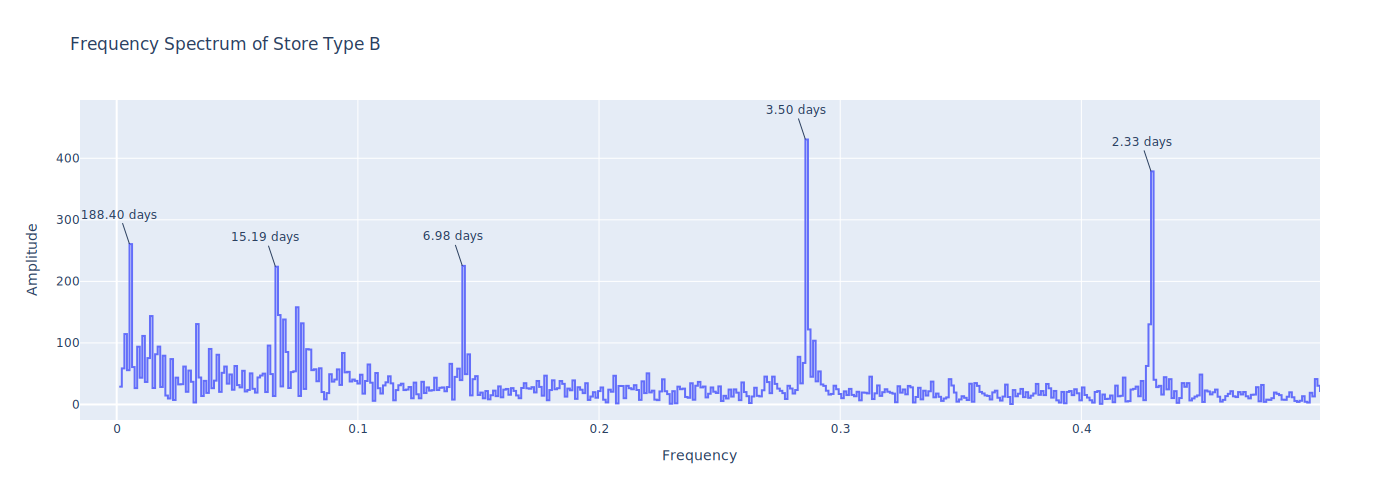

In [96]:
# Most references seem to detrend the data first
# If the series is already level, this won't do much
y_fft = np.fft.fft(temp['y'].to_numpy() - result['trend'])

freq = np.fft.fftfreq(len(y_fft), 1)
amplitude = np.abs(y_fft / len(y_fft))

# Filter the troughs of the signal (sine) wave
# Since they're basically mirror of the peaks
mask = freq > 0

fig = make_subplots()

fig.add_scatter(
    x = freq[mask],
    y = amplitude[mask],
    line_shape = 'hv',
    row = 1, col = 1,
    customdata = 1 / freq[mask],
    hovertemplate =
        'Frequency: %{x:.3f}<br>' +
        'Period: %{customdata:.3f} days<br>' +
        'Amplitude: %{y:.0f}'
)

# Get the indices of top N peaks
peaks = np.argpartition(amplitude[mask], -5)[-5:]

for i in peaks:
    fig.add_annotation(
        x = freq[mask][i],
        y = amplitude[mask][i],
        # Period (days) = 1 / frequency
        text = f'{1 / freq[mask][i]:.2f} days'
    )

fig.update_layout(
    title = 'Frequency Spectrum of Store Type B<br>' +
        '<sup>From sales perspective only (median), not customers</sup>',
    xaxis_title = 'Frequency',
    yaxis_title = 'Amplitude',
    width = 1400
)

fig.show()

We certainly won't be using 3 days since it's too short, and not 14 days either since we're already using 7 days. This left us with the last peak, 188 days (about 6 months)

The fact that 6 months appeared may indicate that there's a yearly season, but since we only have 3 years of data (not enough observation), it only caught up to 6 months instead

---

Let's stick using 7 days and 365 days seasonalities for now, but we need to check further by plotting the autocorrelation (see [chapter 2.6 - 2.8](https://otexts.com/fpp3/scatterplots.html)) of the STL residual

Based on Rob J Hyndman, a good [residual shouldn't have autocorrelation](https://otexts.com/fpp3/regression-evaluation.html#acf-plot-of-residuals) left, if the effect of the trend and seasonalities have been completely removed (only white noise remaining)

In [97]:
# Test different seasonalities here if needed
models = [ sfm.MSTL(season_length = [7, 365]) ]
sf = StatsForecast(models = models, freq = '1d', n_jobs = -1)

result = sf.fit(temp)
result = result.fitted_[0, 0].model_

fig = make_subplots(rows = 2, cols = 1)

# Autocorrelation of the residual
fig = plot_acf(result['remainder'], nlags = 370, zero = False, fig = fig, row = 1, col = 1)
# Histogram (distribution) of the residual
fig.add_histogram(x = result['remainder'], row = 2, col = 1)

fig.update_layout(
    title = 'ACF, PACF, and Histogram of Store Type B<br>' +
        '<sup>Showing the residual of sales (removed trend and seasonalities)</sup>',
    showlegend = False,
    width = 1400,
    height = 600
)

fig.show(renderer = 'vscode')

We can see that the residual still has a cyclical pattern about every 7 days, or 14 days if we consider the full peak-and-trough cycle

Judging by its pattern, it's a seasonal AR because the ACF is slowly decaying. The existence of this pattern means that STL can't fully remove the influence of the weekly seasonility

We can also see very strong correlation at lag 365, but if I change the STL seasonality to 180 days instead, the lag at 180 will also be strong instead so there's no clear winner

On the good side, the histogram shows a normal distribution with mean around 0, which fits the definition of Gaussian [white noise](https://en.wikipedia.org/wiki/White_noise)

---

Based on the previous backing, I will continue using 7 days and 365 days as the seasonalities, and just hope SARIMA(X) will do its magic later

Let's just (re)plot the STL for store type B and store type A, C, D then, since there's nothing more I can do to truly fix the residual

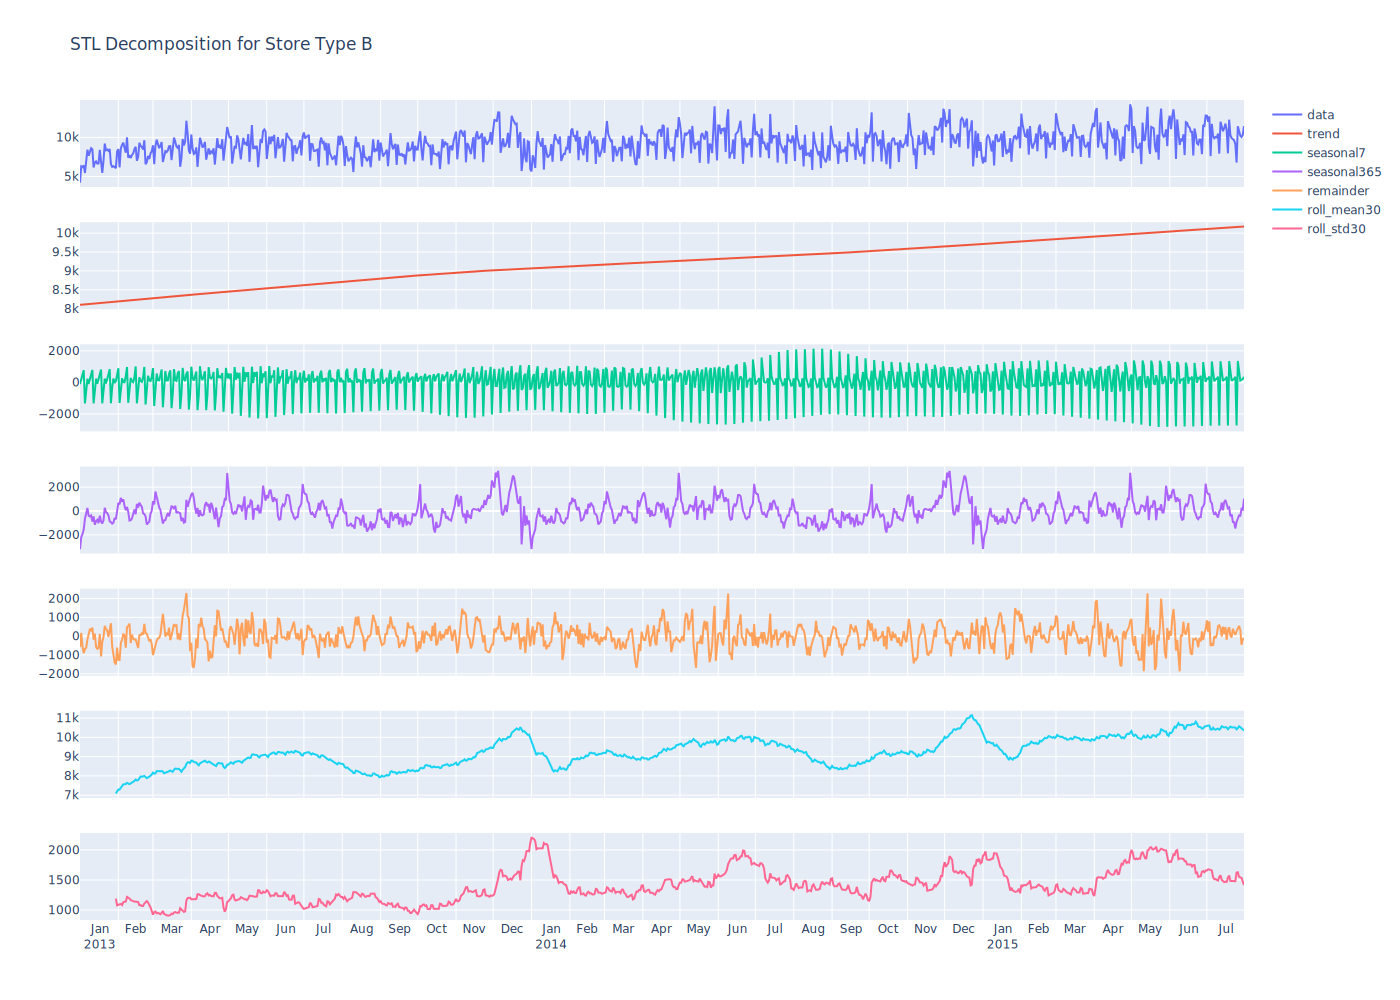

In [98]:
# Same as previous STL code, just removed comments
temp = df['train'].filter(pl.col('StoreType') == 'b'). \
    group_by('Date').agg(pl.col('Sales').median()). \
    sort('Date')

temp = temp.rename({'Date': 'ds', 'Sales': 'y'}).with_columns(
    pl.lit(1).alias('unique_id')
)

models = [ sfm.MSTL(season_length = [7, 365]) ]
sf = StatsForecast(models = models, freq = '1d', n_jobs = -1)

result = sf.fit(temp)
result = result.fitted_[0, 0].model_
cols = [
    *result.columns,
    temp['y'].rolling_mean(30).alias('roll_mean30'),
    temp['y'].rolling_std(30).alias('roll_std30')
]

fig = make_subplots(rows = len(cols), cols = 1, shared_xaxes = True)

for i, col in enumerate(cols):
    fig.add_scatter(
        y = result[col] if type(col) is str else col,
        x = temp['ds'],
        name = col if type(col) is str else col.name,
        row = i + 1, col = 1
    )

fig.update_layout(
    title = 'STL Decomposition for Store Type B<br>' +
        '<sup>From sales perspective only (median), not customers</sup>',
    width = 1400,
    height = 1000
)

fig.update_xaxes(
    dtick = 'M1',
    tickformat = '%b\n%Y',
    ticklabelmode = 'period'
)

fig.show()

Continuing the previous reasoning, if I change the seasonality from 365 days to 180 days, the trend on the STL above will not be truly linear anymore

Non-linear trend is not necessarily bad since we will use differencing later, but having a linear trend is a nice bonus and a sign of long-term stability

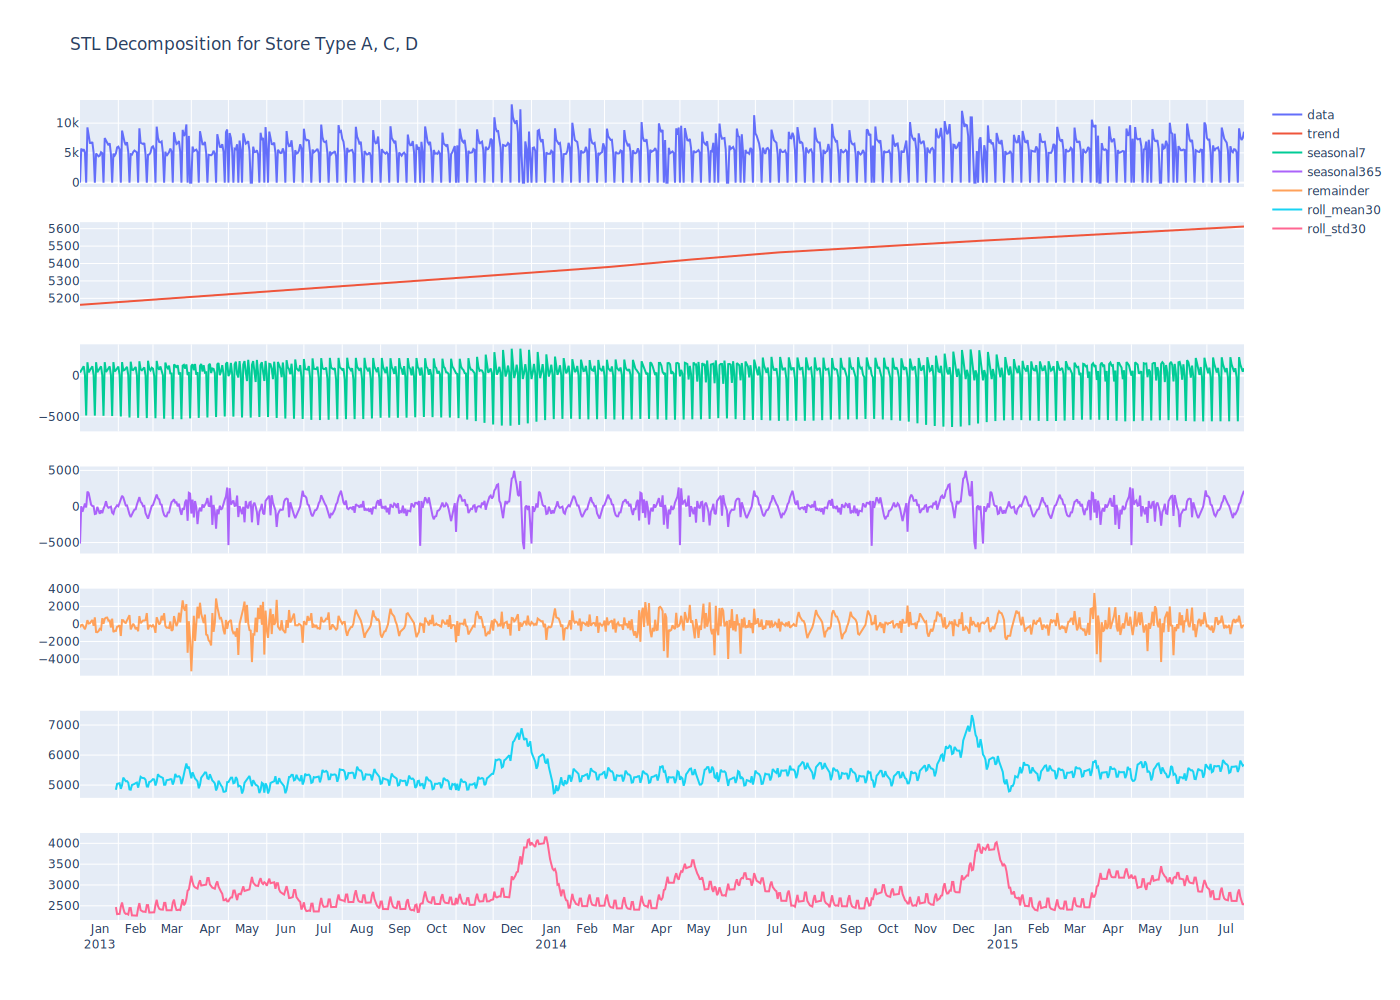

In [99]:
# Same as previous STL code, just changed "== b" to "!= b"
temp = df['train'].filter(pl.col('StoreType') != 'b'). \
    group_by('Date').agg(pl.col('Sales').median()). \
    sort('Date')

temp = temp.rename({'Date': 'ds', 'Sales': 'y'}).with_columns(
    pl.lit(1).alias('unique_id')
)

models = [ sfm.MSTL(season_length = [7, 365]) ]
sf = StatsForecast(models = models, freq = '1d', n_jobs = -1)

result = sf.fit(temp)
result = result.fitted_[0, 0].model_
cols = [
    *result.columns,
    temp['y'].rolling_mean(30).alias('roll_mean30'),
    temp['y'].rolling_std(30).alias('roll_std30')
]

fig = make_subplots(rows = len(cols), cols = 1, shared_xaxes = True)

for i, col in enumerate(cols):
    fig.add_scatter(
        y = result[col] if type(col) is str else col,
        x = temp['ds'],
        name = col if type(col) is str else col.name,
        row = i + 1, col = 1
    )

fig.update_layout(
    title = 'STL Decomposition for Store Type A, C, D<br>' +
        '<sup>From sales perspective only (median), not customers</sup>',
    width = 1400,
    height = 1000
)

fig.update_xaxes(
    dtick = 'M1',
    tickformat = '%b\n%Y',
    ticklabelmode = 'period'
)

fig.show()

Although the characteristics of store type A, C, D (combined) slightly differ from store type B, we still can see the same trend and seasonalities here

We can even see the increase in variance around April - June more clearly on this graph, which doesn't seem to be happening exactly every 365 days

Upon further research, it seems related to Easter day and other irregular holidays. Thankfully, those stores are mostly closed so we can use the `Open` column as indicator

---

Next thing we can notice is, unlike store type B, the mean and standard deviation of store type A, C, D seems to be level (not increasing/decreasing over time)

This means that store type A, C, D (combined) is stationary, while store type B is not stationary (growing mean and standard deviation)

We must keep this in mind since most classical ML models expect stationarity, or require tweaks to the model parametes to work with non-stationarity (e.g. ARIMA)

---

For simplicity, we will focus on sales of store type B only starting now, and assume it's just a single store with the help of "group by" operation

In [100]:
# Take only the important columns (to be used by SARIMAX)
temp = df['train'].filter(pl.col('StoreType') == 'b'). \
    to_dummies('StateHoliday'). \
    group_by('Date').agg(
        pl.col('Sales').median(),
        pl.col('Open').sum(),
        pl.col('Month').first(),
        pl.col('^DayOf.*$').first(),
        pl.col('^.*Holiday.*$').sum(),
    ).sort('Date')

test = df['test'].filter(pl.col('StoreType') == 'b'). \
    to_dummies('StateHoliday'). \
    group_by('Date').agg(
        pl.col('Open').sum(),
        pl.col('Month').first(),
        pl.col('^DayOf.*$').first(),
        pl.col('^.*Holiday.*$').sum(),
    ).sort('Date')

# Split part of train set as validation set
# So we get all 3 sets: train, val, test
train, val = train_test_split(
    temp,
    test_size = 0.2,
    shuffle = False
)

print('Train:', train.shape)
print('Validation:', val.shape)
# Test set is missing the sales column
print('Test:', test.shape)

train.head()

Train: (753, 12)
Validation: (189, 12)
Test: (48, 9)


Date,Sales,Open,Month,DayOfWeek,DayOfMonth,DayOfYear,StateHoliday_Christmas,StateHoliday_Easter,StateHoliday_None,StateHoliday_Public,SchoolHoliday
date,f64,i64,i8,i64,i8,i16,i64,i64,i64,i64,i64
2013-01-01,4220.0,16,1,2,1,1,0,0,0,17,17
2013-01-02,6300.0,16,1,3,2,2,0,0,17,0,17
2013-01-03,6209.0,16,1,4,3,3,0,0,17,0,17
2013-01-04,6430.0,15,1,5,4,4,0,0,17,0,17
2013-01-05,5460.0,15,1,6,5,5,0,0,17,0,3


Continuing the previous problem, according to [this reference](https://otexts.com/fpp3/components.html), growing variance is a sign of multiplicative time series (the TSR components are not completely independent from each other)

STL, ARIMA, and most time series models are designed for additive time series, but we can simply pass the logarithm of the data to make them work on multiplicative time series

This is because $y_t = T_t * S_t * R_t$ is the same as $log ~ y_t = log ~ T_t + log ~ S_t + log ~ R_t$, so we can treat the multiplication problem as an addition problem

Coincidentally, in general, [log transformation](https://otexts.com/fpp3/transformations.html#mathematical-transformations) is used to normalize the variance/standard deviation of a data distribution, so I think these concepts are related

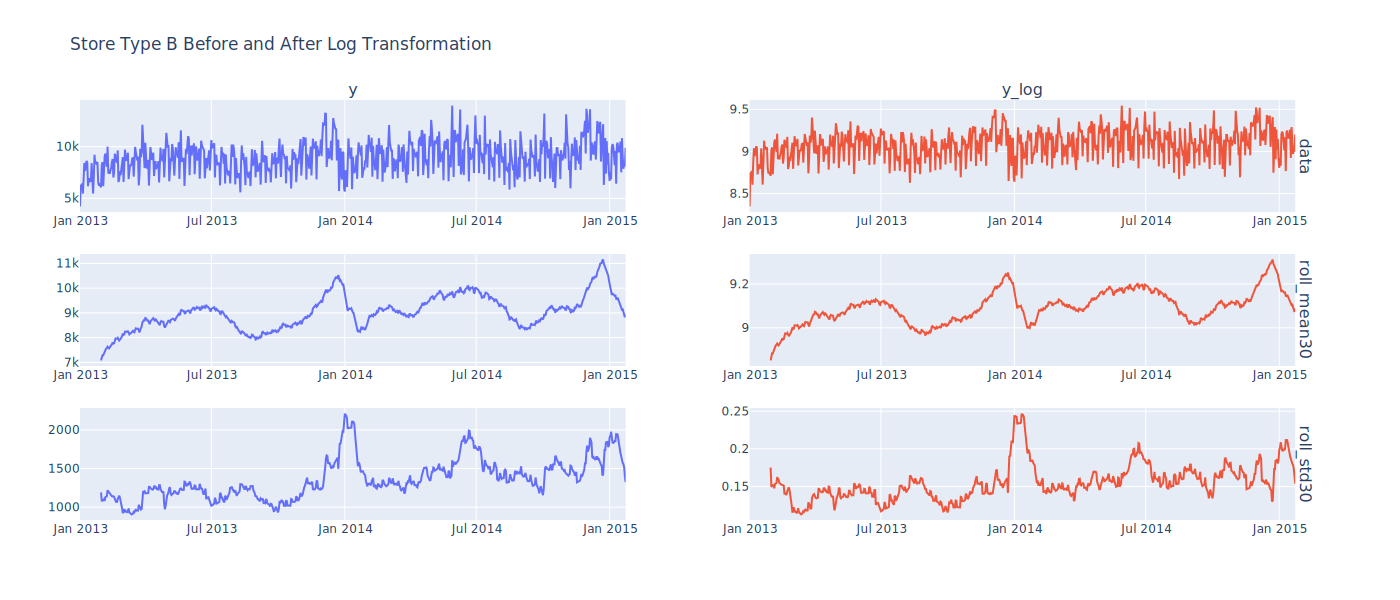

In [101]:
temp = train.select('Date', 'Sales')

temp = temp.rename({'Date': 'ds', 'Sales': 'y'}).with_columns(
    pl.lit(1).alias('unique_id'),
    # Add a small constant to prevent null/inf on log zero
    pl.col('y').add(0.0001).log().alias('y_log')
)

fig = make_subplots(
    rows = 3, cols = 2,
    column_titles = ['y', 'y_log'],
    row_titles = ['data', 'roll_mean30', 'roll_std30']
)

# https://plotly.com/python/discrete-color/
color = ['#636EFA', '#EF553B', '#00CC96', '#19D3F3', '#FF6692', '#FFFF33']

for i, col in enumerate(['y', 'y_log']):
    fig.add_scatter(
        y = temp[col],
        x = temp['ds'],
        marker_color = color[i],
        row = 1, col = i + 1
    )

    fig.add_scatter(
        y = temp[col].rolling_mean(30),
        x = temp['ds'],
        marker_color = color[i],
        row = 2, col = i + 1
    )

    fig.add_scatter(
        y = temp[col].rolling_std(30),
        x = temp['ds'],
        marker_color = color[i],
        row = 3, col = i + 1
    )

fig.update_layout(
    title = 'Store Type B Before and After Log Transformation<br>' +
        '<sup>From sales perspective only (median), not customers</sup>',
    showlegend = False,
    width = 1400,
    height = 600
)

fig.show()

It's not the best, but the standard deviation (last graph) becomes slightly more level after using the log transformation

The mean (2nd graph) is still growing, which is problematic, but we will deal with it using differencing after this

Alternatively, we can also remove the trend directly based on the STL result, but since I'll be using ARIMA, then differencing is more preferred

---

Let's talk about ARIMA ([ref 1](https://otexts.com/fpp3/arima.html), [ref 2](https://nixtlaverse.nixtla.io/statsforecast/docs/models/arima.html)) since it's also related to differencing. In short, ARIMA is a combination of 3 concepts:
1. AR(p): autoregression
    - In an autoregression model, we forecast the variable of interest (e.g. sales) using a linear combination of past values of the variable
    - It's similar to [linear regression](https://otexts.com/fpp3/regression-intro.html), but instead of $x_1, x_2, ..., x_p$ (independent variables), we use $y_{t-1}, y_{t-2}, ..., y_{t-p}$ (past values) to predict $y_t$
    - The formula for AR(p) is $y_{t} = c + \phi_{1}y_{t-1} + \phi_{2}y_{t-2} + ... + \phi_{p}y_{t-p} + \varepsilon_{t}$, where:
        - $\phi_p$ = weight of past value (for $y_{t-p}$)
        - $c$ = constant/bias (sometimes referred as $\phi_0$)
        - $t$ = current time/row
        - $t-p$ = past time (e.g. 1 day before $t$)
        - $\varepsilon$ = white noise (error/residual)
    - Using PACF, we may be able to conclude the right value for $p$
2. MA(q): moving average
    - Similar as autoregression, but it uses the past errors ($\varepsilon$) instead of the past values to predict $y_t$
    - The formula for MA(q) is $y_{t} = c + \theta_{1}\varepsilon_{t-1} + \theta_{2}\varepsilon_{t-2} + ... + \theta_{q}\varepsilon_{t-q} + \varepsilon_t$, where:
        - $\theta_q$ = weight of past error (for $\varepsilon_{t-q}$)
    - Using ACF (see [chapter 2.6 - 2.8](https://otexts.com/fpp3/scatterplots.html)), we may be able to conclude the right value for $q$
3. I(d): integration (the reverse of differencing)
    - [Differencing](https://otexts.com/fpp3/stationarity.html) is oftenly used to normalize trend or growing mean so they become level
    - For first order differencing (linear trend), the formula is $y'_t = y_t - y_{t - 1}$
    - For second order differencing (quadratic trend), the formula is $y''_t = (y_t - y_{t - 1}) - (y_{t - 1} - y_{t - 2})$
    - And so on...

Combining these 3 concepts, the ARIMA (p,d,q) formula becomes $y'_{t} = c + \phi_{1}y'_{t-1} + ... + \phi_{p}y'_{t-p} + \theta_{1}\varepsilon_{t-1} + ... + \theta_{q}\varepsilon_{t-q} + \varepsilon_{t}$

Where $y'_t$ means first difference (`d = 1`), and if we have `d = 2` then it will become $y''_t$ instead

---

SARIMA ([reference](https://otexts.com/fpp3/seasonal-arima.html)) is an extension of ARIMA that can also handle seasonality and seasonal differencing (`m`)

For weekly seasonality, the seasonal differencing (`m`) is basically just $y_t - y_{t-7}$, and it's separate from the original differencing (`D`), so we can apply both

It's formula is similar as ARIMA, but we will have separate $(P,D,Q)_{m}$ order, so the final prediction result will be $(p,d,q) \times (P,D,Q)_{m}$

---

Now let's test the seasonal differencing on our data, combined with the log transformation that we did earlier

However, we shouldn't replace the original value with the differenced value, because SARIMA will do the differencing automatically later

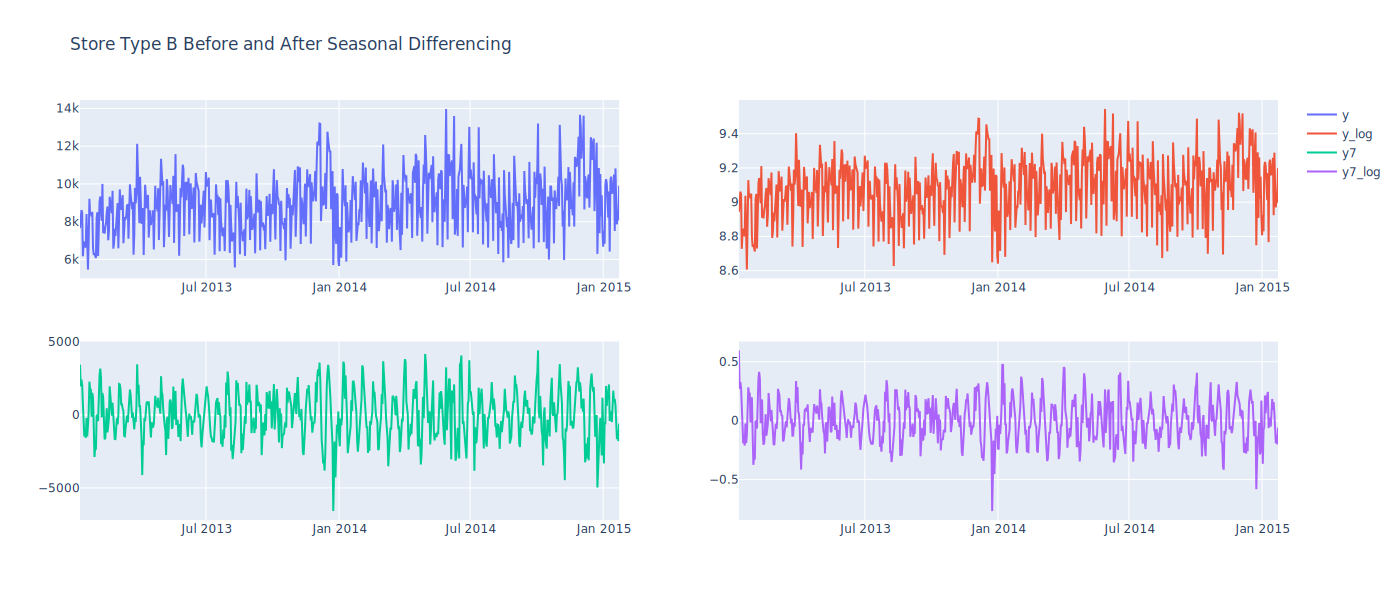

In [102]:
temp = train.select('Date', 'Sales')

# SARIMA only supports 1 seasonality
# We will add the yearly seasonality through SARIMAX later
temp = temp.rename({'Date': 'ds', 'Sales': 'y'}).with_columns(
    pl.lit(1).alias('unique_id'),
    pl.col('y').diff(7).alias('y7'),
    pl.col('y').add(0.0001).log().alias('y_log'),
    pl.col('y').add(0.0001).log().diff(7).alias('y7_log')
).drop_nulls()

fig = make_subplots(rows = 2, cols = 2)

for i, col in enumerate(['y', 'y7']):
    fig.add_scatter(
        x = temp['ds'],
        y = temp[col],
        row = i + 1, col = 1,
        name = col
    )

    fig.add_scatter(
        x = temp['ds'],
        y = temp[col + '_log'],
        row = i + 1, col = 2,
        name = col + '_log'
    )

fig.update_layout(
    title = 'Store Type B Before and After Seasonal Differencing<br>' +
        '<sup>From sales perspective only (median), not customers</sup>',
    showlegend = True,
    width = 1400,
    height = 600
)

fig.show()

After seasonal differencing (green), the mean seems to be level, and after combining it with log transformation (purple), the standard deviation also seem to be more level

But we can't be sure, so let's test the data under various condition involving log transformation and additional differencing

In [103]:
temp = temp.with_columns(
    # 1st order additional differencing (with & without log)
    pl.col('y7').diff().alias('y7_diff'),
    pl.col('y7_log').diff().alias('y7_log_diff'),

    # 2nd order additional differencing (with & without log)
    pl.col('y7').diff().diff().alias('y7_diff2'),
    pl.col('y7_log').diff().diff().alias('y7_log_diff2')
).drop_nulls()

temp.head()

ds,y,unique_id,y7,y_log,y7_log,y7_diff,y7_log_diff,y7_diff2,y7_log_diff2
date,f64,i32,f64,f64,f64,f64,f64,f64,f64
2013-01-10,8616.0,1,2407.0,9.061376,0.327621,454.0,0.057594,1940.0,0.383613
2013-01-11,8486.0,1,2056.0,9.046173,0.277443,-351.0,-0.050178,-805.0,-0.107772
2013-01-12,6168.0,1,708.0,8.72713,0.121926,-1348.0,-0.155517,-997.0,-0.105339
2013-01-13,6797.0,1,-311.0,8.824237,-0.04474,-1019.0,-0.166665,329.0,-0.011148
2013-01-14,6942.0,1,-1484.0,8.845345,-0.193732,-1173.0,-0.148993,-154.0,0.017673


Now we will see the effect of additional differencing on the time series, and how does it affect the mean and standard deviation of the data

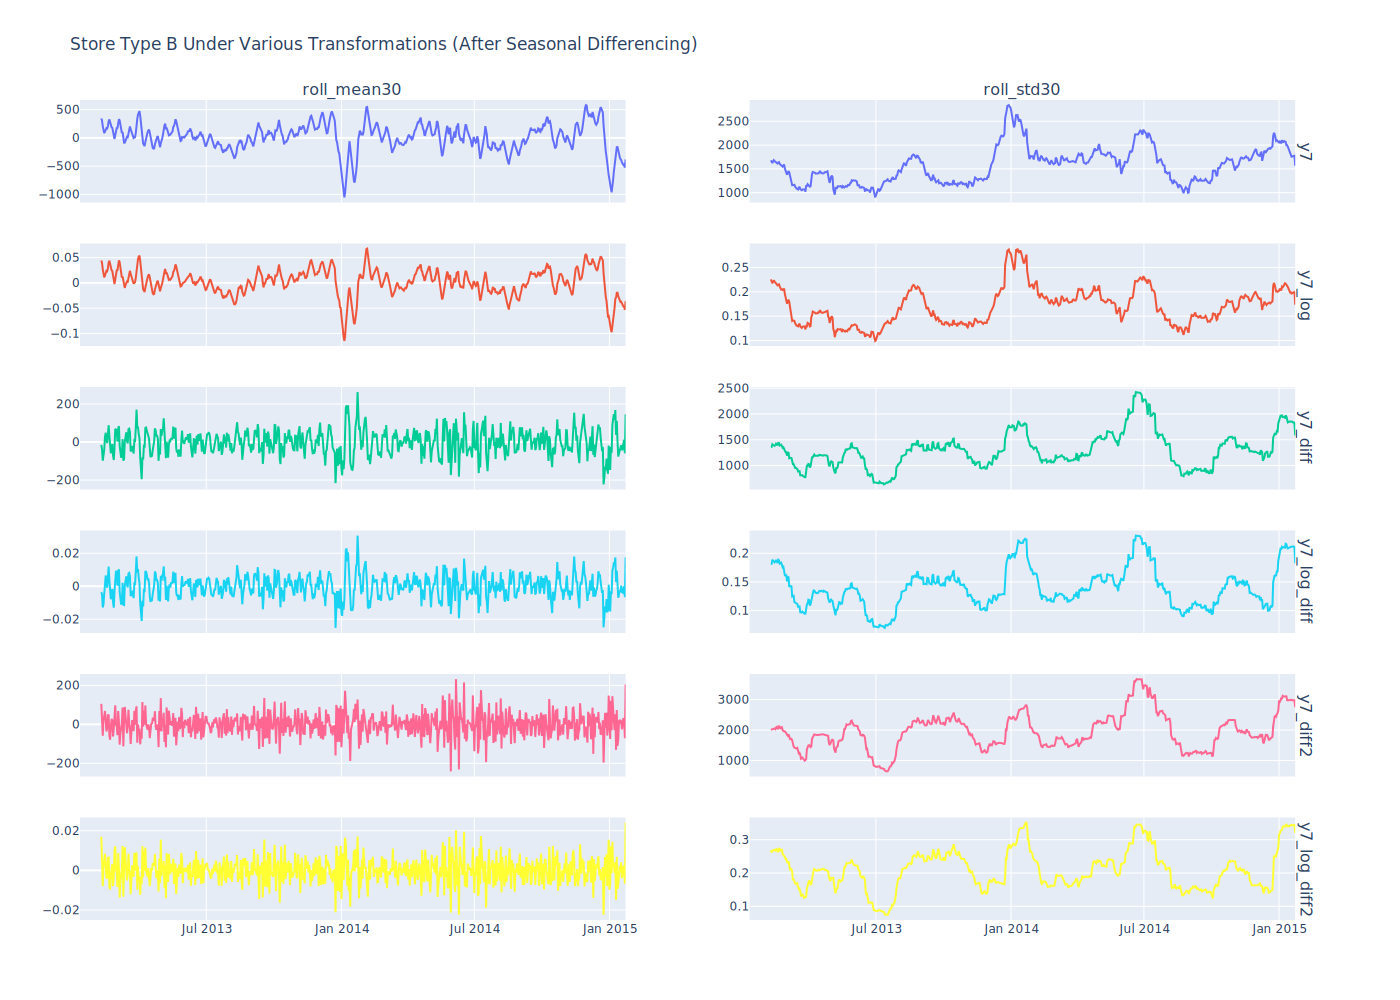

In [104]:
cols = ['y7', 'y7_log', 'y7_diff', 'y7_log_diff', 'y7_diff2', 'y7_log_diff2']

# https://plotly.com/python/discrete-color/
color = ['#636EFA', '#EF553B', '#00CC96', '#19D3F3', '#FF6692', '#FFFF33']

fig = make_subplots(
    rows = 6, cols = 2,
    shared_xaxes = True,
    column_titles = ['roll_mean30', 'roll_std30'],
    row_titles = cols
)

for i, col in enumerate(cols):
    fig.add_scatter(
        y = temp[col].rolling_mean(30),
        x = temp['ds'],
        marker_color = color[i],
        row = i + 1, col = 1
    )

    fig.add_scatter(
        y = temp[col].rolling_std(30),
        x = temp['ds'],
        marker_color = color[i],
        row = i + 1, col = 2
    )

fig.update_layout(
    title = 'Store Type B Under Various Transformations (After Seasonal Differencing)<br>' +
        '<sup>From sales perspective only (median), not customers</sup>',
    showlegend = False,
    width = 1400,
    height = 1000
)

fig.show()

I think the standard deviation on `y7` and `y7_log` are already level (not actively increasing/decreasing), so we may not need `y7_log` (only `y7` remains)

The mean on `y7` is also pretty much level, even more stable than the standard deviation, but still increase temporarily on January each year

The additional differencing (`y7_diff`) seems to fix this problem, so we can stop at that because further differencing (`y7_diff2`) is an overkill

Rob J Hynman also stated that we should "do as few differences as necessary to obtain a stationary series" ([reference](https://otexts.com/fpp3/stationarity.html))

---

Therefore we can conclude that the right I(D) parameter for SARIMA is `D = 1` (`y7_diff`), though we can reconsider it after seeing the ACF and PACF

Let's plot the ACF and PACF to see which difference order is better, and also to conclude the right parameters for AR(P) and MA(Q)

In [105]:
fig = make_subplots(
    rows = 3, cols = 2,
    column_titles = ['Autocorrelation', 'Partial Autocorrelation'],
    row_titles = ['y7', 'y7_diff', 'y7_diff2']
)

for i, col in enumerate(['y7', 'y7_diff', 'y7_diff2']):
    plot_acf(temp[col], nlags = 80, fig = fig, row = i + 1, col = 1)
    plot_pacf(temp[col], nlags = 80, fig = fig, row = i + 1, col = 2)

fig.update_layout(
    title = 'Autocorrelations of Store Type B (After Seasonal Differencing)<br>' +
        '<sup>From sales perspective only (median), not customers</sup>',
    showlegend = False,
    width = 1400,
    height = 1000
)

fig.show(renderer = 'vscode')

Rob J Hyndman has a brief section explaining how to choose p/P and q/Q order ([reference](https://otexts.com/fpp3/non-seasonal-arima.html#acf-and-pacf-plots)), and the Duke University also has a good explanation ([reference](https://people.duke.edu/~rnau/411arim3.htm))

---

`y7` looks pretty good, but the non-stationary cyclical pattern stands out too much, so I'm not sure whether to use it or not

`y7_diff` is a bit better, and because the PACF is slowly decaying every 7 lags (while the ACF is strong), it's probably an MA model

Therefore, I think the best (P,D,Q) order is (0,1,7), but let's see what auto ARIMA think is the best

In [47]:
models = [
    sfm.AutoARIMA(
        seasonal = True,
        season_length = 7,
        max_P = 7,
        D = 1,
        max_Q = 7,
        # We won't get to the non-seasonal part yet
        # So we set them all to zero
        max_p = 0,
        max_d = 0,
        max_q = 0,
        # Force brute-force
        max_order = 999,
        stepwise = False,
        trace = True
    )
]

sf = StatsForecast(models = models, freq = '1d')
_ = sf.fit(temp.select('y', 'ds', 'unique_id'))


ARIMA(0,0,0)(0,1,0)[7]                   :12968.003206385618

ARIMA(0,0,0)(0,1,0)[7] with drift        :12969.946268971895

ARIMA(0,0,0)(0,1,1)[7]                   :12539.022814856075

ARIMA(0,0,0)(0,1,1)[7] with drift        :12537.249017770897

ARIMA(0,0,0)(0,1,2)[7]                   :12527.877382846567

ARIMA(0,0,0)(0,1,2)[7] with drift        :12528.102745895749

ARIMA(0,0,0)(0,1,3)[7]                   :12500.47662935933

ARIMA(0,0,0)(0,1,3)[7] with drift        :12495.91768413845

ARIMA(0,0,0)(0,1,4)[7]                   :12502.263058210821

ARIMA(0,0,0)(0,1,4)[7] with drift        :12496.652420550108

ARIMA(0,0,0)(0,1,5)[7]                   :12472.067664841856

ARIMA(0,0,0)(0,1,5)[7] with drift        :12463.701403712057

ARIMA(0,0,0)(0,1,6)[7]                   :12469.07320351997

ARIMA(0,0,0)(0,1,6)[7] with drift        :12460.950929720959

ARIMA(0,0,0)(0,1,7)[7]                   :12461.507368280192

ARIMA(0,0,0)(0,1,7)[7] with drift        :inf

ARIMA(0,0,0)(1,1,0)[7]   

According to auto ARIMA, the order with less error are (2,1,5) at 12452, (6,1,2) at 12453, (1,1,5) at 12455, and (1,1,6) and (1,1,7) both at 12458

Most of these seems coincidental, since the ACF before lag 7 are all weak, and as for (1,1,7), I don't think the ACF of `y7_diff` has a decay after lag 1

My original guess, (0,1,7), has an error of 12461, which isn't that bad, so I decided to stick to it

---

Now let's get to the non-seasonal part of the SARIMA, the (p,d,q) part instead of (P,D,Q)

To estimate the (p,d,q), we simply need to plot the ACF and PACF of the residual of $(0,0,0) \times (0,1,7)_7$

In [106]:
models = [
    sfm.ARIMA(
        order = (0, 0, 0),
        seasonal_order = (0, 1, 7),
        season_length = 7
    )
]

sf = StatsForecast(models = models, freq = '1d')
sf.fit(temp.select('y', 'ds', 'unique_id'))

temp2 = sf.fitted_[0][0].model_['residuals']

fig = make_subplots(
    rows = 1, cols = 2,
    column_titles = ['Autocorrelation', 'Partial Autocorrelation']
)

plot_acf(temp2, nlags = 80, fig = fig, row = 1, col = 1)
plot_pacf(temp2, nlags = 80, fig = fig, row = 1, col = 2)

fig.update_layout(
    title = 'Autocorrelations of Store Type B (Seasonal Residual)<br>' +
        '<sup>From sales perspective only (median), not customers</sup>',
    showlegend = False,
    width = 1400,
    height = 400
)

fig.show(renderer = 'vscode')

The residual most likely has a (p,d,q) order of (1,0,0), hence our final SARIMA model becomes $(1,0,0) \times (0,1,7)_7$

RMSE (validation set): 1393.4935813008228


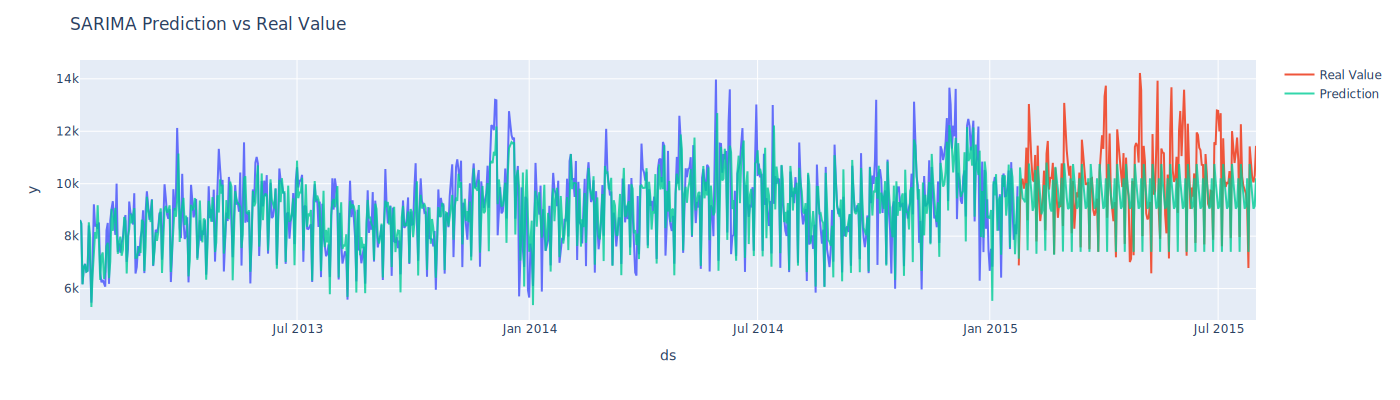

In [107]:
models = [
    sfm.ARIMA(
        order = (1, 0, 0),
        seasonal_order = (0, 1, 7),
        season_length = 7
    )
]

sf = StatsForecast(models = models, freq = '1d')

# The validation set has 189 rows, so we predict for 189 days
temp2 = sf.forecast(h = 189, df = temp.select('y', 'ds', 'unique_id'), fitted = True)
temp2 = pl.concat([sf.forecast_fitted_values().drop('y'), temp2], how = 'vertical')

fig = px.line(temp, 'ds', 'y')

fig.update_layout(
    title = 'SARIMA Prediction vs Real Value<br>' +
        '<sup>From sales perspective only (median), not customers</sup>',
    width = 1400,
    height = 400
)

fig.add_scatter(
    x = val['Date'],
    y = val['Sales'],
    name = 'Real Value'
)

fig.add_scatter(
    x = temp2['ds'],
    y = temp2['ARIMA'],
    opacity = 0.8,
    name = 'Prediction'
)

print('RMSE (validation set):', rmse(val['Sales'], temp2['ARIMA'].tail(189)).mean())

fig.show()

That's pretty bad (the last 189 predictions), and perhaps it's because we didn't consider the yearly seasonality (see also [long-term prediction](https://otexts.com/fpp3/non-seasonal-arima.html#understanding-arima-models))

Let's check the prediction residual in case our model has the wrong p,d,q or P,D,Q order

Note that the residual is the error from the fitted dataframe only (the train set), as the validation set is considered the future

In [108]:
sf.fit(temp.select('y', 'ds', 'unique_id'))
temp2 = sf.fitted_[0][0].model_['residuals']

fig = make_subplots(
    rows = 1, cols = 2,
    column_titles = ['Autocorrelation', 'Partial Autocorrelation']
)

plot_acf(temp2, nlags = 80, fig = fig, row = 1, col = 1)
plot_pacf(temp2, nlags = 80, fig = fig, row = 1, col = 2)

fig.update_layout(
    title = 'Autocorrelations of Store Type B (Prediction Residual)<br>' +
        '<sup>From sales perspective only (median), not customers</sup>',
    showlegend = False,
    width = 1400,
    height = 400
)

fig.show(renderer = 'vscode')

## SARIMAX

The residual doesn't have any significant correlation (the strongest one is only 0.1), so the p,d,q and P,D,Q order may not be the problem here

Let's use SARIMAX ([reference](https://phosgene89.github.io/sarima.html)) to account the yearly seasonality and hope that it will improve the result

SARIMAX formula is similar to SARIMA, with added linear regression to support $x_1, x_2, ..., x_n$ (exogenous variables)

In [109]:
train.head()

Date,Sales,Open,Month,DayOfWeek,DayOfMonth,DayOfYear,StateHoliday_Christmas,StateHoliday_Easter,StateHoliday_None,StateHoliday_Public,SchoolHoliday
date,f64,i64,i8,i64,i8,i16,i64,i64,i64,i64,i64
2013-01-01,4220.0,16,1,2,1,1,0,0,0,17,17
2013-01-02,6300.0,16,1,3,2,2,0,0,17,0,17
2013-01-03,6209.0,16,1,4,3,3,0,0,17,0,17
2013-01-04,6430.0,15,1,5,4,4,0,0,17,0,17
2013-01-05,5460.0,15,1,6,5,5,0,0,17,0,3


To help SARIMAX understand the yearly (and potentially other) seasonality, we need to use Fourier transform ([ref 1](https://medium.com/intive-developers/forecasting-time-series-with-multiple-seasonalities-using-tbats-in-python-398a00ac0e8a), [ref 2](https://en.wikipedia.org/wiki/Fourier_series), [ref 3](https://otexts.com/fpp3/useful-predictors.html))

After the transformation, the model understand cyclic period better. For example, that 31 December and 1 January is just a day difference

The higher the Fourier terms, the resulting seasonal pattern will become more sensitive/wiggly ([reference](https://otexts.com/fpp3/dhr.html))

In [110]:
def cylical_encoding(df: pl.DataFrame, period_terms: dict[str, list[int]]) -> pl.DataFrame:
    # Period and the Fourier terms
    for key, (val, terms) in period_terms.items():
        for term in range(1, terms + 1):
            df = df.with_columns(
                pl.col(key).mul(2 * np.pi * term / val).sin().alias(f'{key}_sin{term}'),
                pl.col(key).mul(2 * np.pi * term / val).cos().alias(f'{key}_cos{term}'),
            )

        df = df.drop(key)

    return df

period_terms = {'Month': [12, 1], 'DayOfWeek': [7, 1], 'DayOfMonth': [31, 2], 'DayOfYear': [366, 3]}
cylical_encoding(train, period_terms).head()

Date,Sales,Open,StateHoliday_Christmas,StateHoliday_Easter,StateHoliday_None,StateHoliday_Public,SchoolHoliday,Month_sin1,Month_cos1,DayOfWeek_sin1,DayOfWeek_cos1,DayOfMonth_sin1,DayOfMonth_cos1,DayOfMonth_sin2,DayOfMonth_cos2,DayOfYear_sin1,DayOfYear_cos1,DayOfYear_sin2,DayOfYear_cos2,DayOfYear_sin3,DayOfYear_cos3
date,f64,i64,i64,i64,i64,i64,i64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
2013-01-01,4220.0,16,0,0,0,17,17,0.5,0.866025,0.974928,-0.222521,0.201299,0.97953,0.394356,0.918958,0.017166,0.999853,0.034328,0.999411,0.051479,0.998674
2013-01-02,6300.0,16,0,0,17,0,17,0.5,0.866025,0.433884,-0.900969,0.394356,0.918958,0.724793,0.688967,0.034328,0.999411,0.068615,0.997643,0.102821,0.9947
2013-01-03,6209.0,16,0,0,17,0,17,0.5,0.866025,-0.433884,-0.900969,0.571268,0.820763,0.937752,0.347305,0.051479,0.998674,0.102821,0.9947,0.153891,0.988088
2013-01-04,6430.0,15,0,0,17,0,17,0.5,0.866025,-0.974928,-0.222521,0.724793,0.688967,0.998717,-0.050649,0.068615,0.997643,0.136906,0.990584,0.204552,0.978856
2013-01-05,5460.0,15,0,0,17,0,3,0.5,0.866025,-0.781831,0.62349,0.848644,0.528964,0.897805,-0.440394,0.085731,0.996318,0.17083,0.985301,0.254671,0.967028


In [111]:
# Statsforecast format for the training set
temp = train.rename({'Date': 'ds', 'Sales': 'y'})
temp = temp.with_columns(pl.lit(1).alias('unique_id'))
temp = cylical_encoding(temp, period_terms)

# Statsforecast format for the validation set
temp2 = val.rename({'Date': 'ds'}).drop('Sales')
temp2 = temp2.with_columns(pl.lit(1).alias('unique_id'))
temp2 = cylical_encoding(temp2, period_terms)

models = [
    sfm.ARIMA(
        order = (1, 0, 0),
        seasonal_order = (0, 1, 7),
        season_length = 7
    )
]

sf = StatsForecast(models = models, freq = '1d')

temp3 = sf.forecast(h = 189, df = temp, X_df = temp2, fitted = True)
temp3 = pl.concat([sf.forecast_fitted_values().drop('y'), temp3], how = 'vertical')

In [112]:
fig = px.line(temp, 'ds', 'y')

fig.update_layout(
    title = 'SARIMAX Prediction vs Real Value<br>' +
        '<sup>From sales perspective only (median), not customers</sup>',
    width = 1400,
    height = 400
)

fig.add_scatter(
    x = val['Date'],
    y = val['Sales'],
    name = 'Real Value'
)

fig.add_scatter(
    x = temp3['ds'],
    y = temp3['ARIMA'],
    opacity = 0.8,
    name = 'Prediction'
)

print('RMSE (validation set):', rmse(val['Sales'], temp3['ARIMA'].tail(189)).mean())

fig.show(renderer = 'vscode')

RMSE (validation set): 1094.2290505508895


Voila! It's much better now (at the last 189 predictions). However, based on my experiments:
- When using to dummies then sum of holiday, the model will make better trough prediction (like the above graph)
- But when using mode of holiday (then to dummies), the model will make better peak prediction
- I kinda liked the better peak prediction, but it has higher RMSE compared to the original SARIMA

Now let's use the SARIMAX to predict the test set (using the train and validation sets to fit the model)

In [113]:
temp = pl.concat([train, val], how = 'vertical')
temp = temp.rename({'Date': 'ds', 'Sales': 'y'})
temp = temp.with_columns(pl.lit(1).alias('unique_id'))
temp = cylical_encoding(temp, period_terms)

# Statsforecast format for the test set
temp2 = test.rename({'Date': 'ds'})
temp2 = temp2.with_columns(
    pl.lit(1).alias('unique_id'),
    # Not available on the test set
    pl.lit(0).alias('StateHoliday_Easter'),
    pl.lit(0).alias('StateHoliday_Christmas')
)
temp2 = cylical_encoding(temp2, period_terms)

models = [
    sfm.ARIMA(
        order = (1, 0, 0),
        seasonal_order = (0, 1, 7),
        season_length = 7
    )
]

sf = StatsForecast(models = models, freq = '1d')
temp3 = sf.forecast(h = 48, df = temp, X_df = temp2)

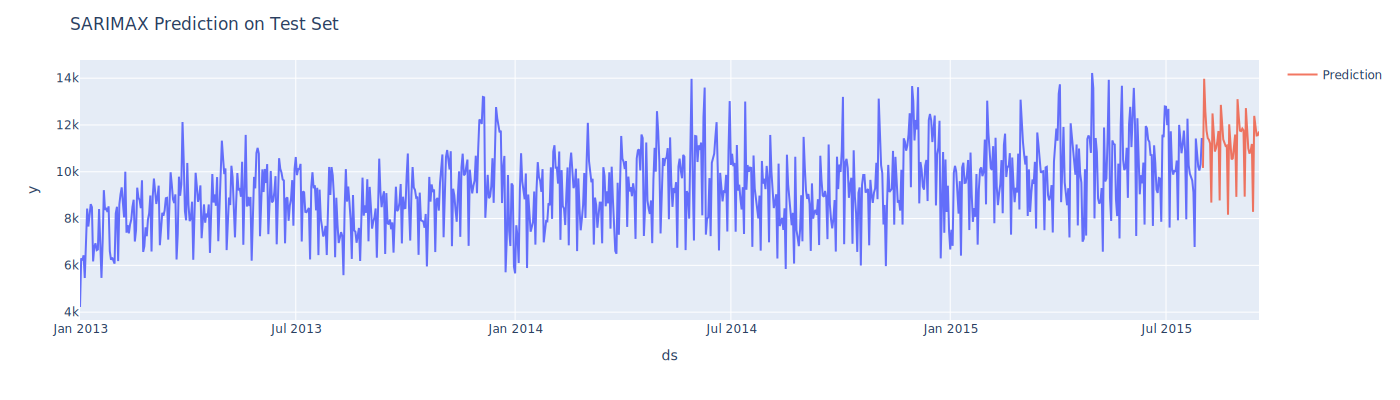

In [114]:
fig = px.line(temp, 'ds', 'y')

fig.update_layout(
    title = 'SARIMAX Prediction on Test Set<br>' +
        '<sup>From sales perspective only (median), not customers</sup>',
    width = 1400,
    height = 400
)

fig.add_scatter(
    x = temp3['ds'],
    y = temp3['ARIMA'],
    opacity = 0.8,
    name = 'Prediction'
)

fig.show()

Judging by the previous cycles, the value should have gone down on July, but SARIMAX predicted upward trend instead

Let's see if the residual has autocorrelation

In [115]:
sf.fit(temp)
temp3 = sf.fitted_[0][0].model_['residuals']

fig = make_subplots(
    rows = 1, cols = 2,
    column_titles = ['Autocorrelation', 'Partial Autocorrelation']
)

plot_acf(temp3, nlags = 80, fig = fig, row = 1, col = 1)
plot_pacf(temp3, nlags = 80, fig = fig, row = 1, col = 2)

fig.update_layout(
    title = 'Autocorrelations of Store Type B (Prediction Residual)<br>' +
        '<sup>From sales perspective only (median), not customers</sup>',
    showlegend = False,
    width = 1400,
    height = 400
)

fig.show(renderer = 'vscode')

Neat, there's no significant autocorrelation here, so there's nothing much to fix (other than picking other SARIMA order from scratch)

After searching for a while, I think this is the weakness of ARIMA based model. This can be mitigated by using rolling forecast ([reference](https://www.kaggle.com/code/nholloway/seasonality-and-sarimax))

Rolling forecast works by refitting the model everytime a new test data comes in, but we can't use it yet because the test data is still totally unknown

## MSTL

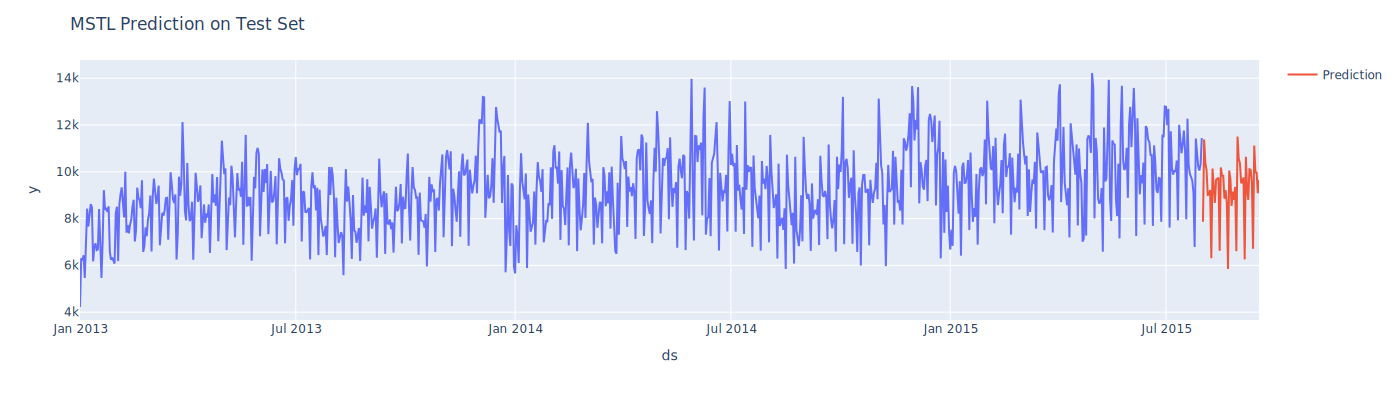

In [116]:
models = [ sfm.MSTL(season_length = [7, 365]) ]

sf = StatsForecast(models = models, freq = '1d')
temp3 = sf.forecast(h = 48, df = temp, fitted = True)

fig = px.line(temp, 'ds', 'y')

fig.update_layout(
    title = 'MSTL Prediction on Test Set<br>' +
        '<sup>From sales perspective only (median), not customers</sup>',
    width = 1400,
    height = 400
)

fig.add_scatter(
    x = temp3['ds'],
    y = temp3['MSTL'],
    name = 'Prediction'
)

fig.show()

Out of curiousity, I used MSTL to make a prediction too (instead of just decomposition) with ETS as the backend

It's very fast and predicted a downward trend in this case. However, it produced a higher RMSE (1548) on the validation set compared to SARIMAX (1094)

I also tried MFLES and TBATS before this ([multi-seasonalities reference](https://nixtlaverse.nixtla.io/statsforecast/index.html#multiple-seasonalities)), but it doesn't look as good as MSTL on the test set

## TODO

Hierarchial forecasting ([reference](https://otexts.com/fpp3/hierarchical.html)). Nixtla also has it